In [1]:
import pandas as pd
import re
import warnings
import torch
from torchvision import datasets, transforms
from scipy.misc import face
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from collections import Counter
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import numpy as np
import random
from tqdm import tqdm
import seaborn as sns

# Data processing

In [2]:
def resetSeed(seed=69):
    torch.manual_seed(69)
    torch.cuda.manual_seed_all(69)
    np.random.seed(69)
    random.seed(69)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

In [3]:
def get_data():
    
    path_train = r'C:\Users\Søren\OneDrive - Danmarks Tekniske Universitet\DTU\Bachelor\4. semester\Project work - Bachelor of Artificial Intelligence and Data\Mura_data\MURA-v1.1\train'
    path_test = r'C:\Users\Søren\OneDrive - Danmarks Tekniske Universitet\DTU\Bachelor\4. semester\Project work - Bachelor of Artificial Intelligence and Data\Mura_data\MURA-v1.1\valid'

    transform = transforms.Compose([transforms.Resize((224, 224)), 
                                    #transforms.RandomResizedCrop(128),
                transforms.ToTensor()])

    master_train = datasets.ImageFolder(path_train, transform = transform)

    dataset_train, dataset_valid = torch.utils.data.random_split(master_train, [int(np.floor(0.7*len(master_train))), int(np.ceil(0.3*len(master_train)))])
    dataset_test = datasets.ImageFolder(path_test, transform = transform)

    train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
    valid = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=True)
    test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=True)

    return train, valid, test, 


In [4]:
resetSeed(seed=69)
train, valid, test = get_data()

# Tjek random seed

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


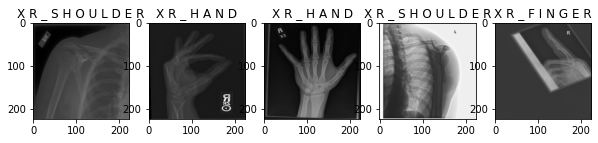

images shape on batch size = torch.Size([32, 3, 224, 224])
labels shape on batch size = torch.Size([32])


In [5]:
def train_imshow():
    classes = ('XR_ELBOW',
 'XR_FINGER',
 'XR_FOREARM',
 'XR_HAND',
 'XR_HUMERUS',
 'XR_SHOULDER',
 'XR_WRIST')
    dataiter = iter(train)
    images, labels = dataiter.next()
    fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0))  # permute?
        ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
        print(images[i].shape)  # Not needed
    plt.show()
    print('images shape on batch size = {}'.format(images.size()))
    print('labels shape on batch size = {}'.format(labels.size()))
train_imshow()

# ANN

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 16, 5)
        self.conv4 = nn.Conv2d(16, 32, 5)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(32*49*49, 120)
        self.fc2 = nn.Linear(120, 12)
        self.fc3 = nn.Linear(12, 7)
        
    def forward(self, x):
        
        #x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        #x = torch.flatten(x, -1) # flatten all dimensions except batch
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        #return x
        
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))   
        x = x.view(x.size(0), -1)
        #x = torch.flatten(x, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.dropout(x, 0.5)
        x = self.fc3(x)                       
        #x = F.softmax(x,dim=1)                
        return x
        

        
#find out features from dim, and image size


input = torch.randn(224, 224)
print(Net())
#print(input.shape)
#input = input.view(1, -1)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=76832, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=12, bias=True)
  (fc3): Linear(in_features=12, out_features=7, bias=True)
)


# Training

In [7]:
# pip install -U ray

In [7]:
device = torch.device("cuda")
#net = AlexNet()
net = Net()
net.to(device)
#net.load_state_dict(torch.load(r"C:\Users\sebas\Desktop\model\ModelAlex0"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

if torch.cuda.is_available():
    net = net.cuda()
    criterion = criterion.cuda()

In [9]:
def validating_model(model):
    accuracies = []
    with torch.no_grad():
        correct = 0
        count = 0

        for i, data_valid in enumerate(valid):
            inputs_valid, labels_valid = data_valid
            inputs_valid, labels_valid = inputs_valid.cuda(), labels_valid.cuda()

            ## Forward Pass
            outputs_valid = model(inputs_valid)
            _, predictions = torch.max(outputs_valid.data, 1)
            count += labels_valid.size(0)
            correct += (predictions == labels_valid).sum().item()

        accuracies.append(correct/count*100)
    return accuracies

In [16]:
%%time



def training_model(model,num_epochs = 2):
    bob = [0.0001, 0.001]
    for i in bob:
        optimizer = optim.Adam(net.parameters(), lr=i)
        loss_values = []
        accuracy = []
        for epoch in tqdm(range(num_epochs)): # epoch -> GPU training time for 1 epoch is 2 min
            loss_ep = 0
        #running_loss = 0.0


            for i, data in enumerate(train):
                inputs, labels = data
                inputs, labels = inputs.cuda(), labels.cuda()

                ## Forward Pass
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                loss_ep += loss.item()

                #running_loss += loss.item()
            loss_values.append(loss_ep/len(train))


            print(f"Loss in epoch {epoch+1} : {loss_ep/len(train)}")
            accuracies = validating_model(model)
            accuracy.append(accuracies)

        plt.plot(np.array(loss_values), 'r')
        plt.legend(['Baseline epoch loss'])
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        print("Training done :D")
        print(i, accuracy)


Wall time: 0 ns


In [11]:
# %%time
# training_model(net)

In [17]:
%%time
acc_val = training_model(net)

  0%|                                                                                            | 0/2 [02:40<?, ?it/s]


KeyboardInterrupt: 

In [13]:
import matplotlib.pyplot as plt
epochs = range(1, len(acc_val) + 1)

plt.plot(epochs, acc_val, label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.xticks(epochs)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.figure()
# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()

plt.show()

TypeError: object of type 'NoneType' has no len()

In [ ]:
# torch.save(net.state_dict(), r"Baseline_model")

In [ ]:
# net.load_state_dict(torch.load(r"Baseline_model"))    

In [ ]:
# print(net)

In [ ]:
def testing_model(model):
    torch.manual_seed(69)
    torch.cuda.manual_seed_all(69)
    np.random.seed(69)
    random.seed(69)
    with torch.no_grad():
            correct = 0
            count = 0

            for i, data_valid in enumerate(tqdm(test)):
                inputs_valid, labels_valid = data_valid
                inputs_valid, labels_valid = inputs_valid.cuda(), labels_valid.cuda()

                ## Forward Pass
                outputs_valid = model(inputs_valid)
                _, predictions = torch.max(outputs_valid.data, 1)
                count += labels_valid.size(0)
                correct += (predictions == labels_valid).sum().item()

            print("Validation - prediction score:", correct/count*100, "%")
            print("Done")

In [ ]:
testing_model(net)


In [ ]:
bob = [0.0001, 0.001, 0.01, 0.1]

for i in bob:
    print(i)
    print(bob)




In [8]:
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import KFold

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms

In [9]:
path_train = r'C:\Users\Søren\OneDrive - Danmarks Tekniske Universitet\DTU\Bachelor\4. semester\Project work - Bachelor of Artificial Intelligence and Data\Mura_data\MURA-v1.1\train'
path_test = r'C:\Users\Søren\OneDrive - Danmarks Tekniske Universitet\DTU\Bachelor\4. semester\Project work - Bachelor of Artificial Intelligence and Data\Mura_data\MURA-v1.1\valid'

transform = transforms.Compose([transforms.Resize((224, 224)), 
                                #transforms.RandomResizedCrop(128),
            transforms.ToTensor()])

master_train = datasets.ImageFolder(path_train, transform = transform)

dataset_train, dataset_valid = torch.utils.data.random_split(master_train, [int(np.floor(0.7*len(master_train))), int(np.ceil(0.3*len(master_train)))])

print(ConcatDataset([dataset_train,dataset_valid]))
print(len(dataset_valid))

11029


In [10]:

dataset = ConcatDataset([dataset_train, dataset_valid])

criterion = nn.CrossEntropyLoss()
num_epochs=20
batch_size = 32
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=69)
foldperf={}

In [11]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    train_loss, train_correct = 0.0, 0
    model.train()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        #loss = loss_fn(output, labels)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss, train_correct

In [12]:
def valid_epoch(model, device, dataloader, loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        #loss = loss_fn(output, labels)
        loss = criterion(output, labels)
        valid_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        val_correct += (predictions == labels).sum().item()

    return valid_loss, val_correct


#l2_param = [0.05, 0.1, 0.15, 0.2, 0.25]
#lr_param = [0.0001, 0.0003, 0.0005,0.0007, 0.001]
l2_param = [0, 0.1, 0.25, 0.5]
lr_param = [0.0001, 0.001, 0.01]

In [ ]:
%%time
count = 0
alt_liste = []

for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#     model = Net()
#     model.to(device)
    
    for i in lr_param:
        for j in l2_param:
            print(i,j)
            model = Net()
            model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=i, weight_decay=j)

            history = {'train_loss': [], 'validation_loss': [], 'train_acc': [], 'validation_acc': []}
            
            for epoch in tqdm(range(num_epochs)):
                train_loss, train_correct = train_epoch(model, device, train_loader, criterion, optimizer)
                test_loss, test_correct = valid_epoch(model, device, test_loader, criterion)

                train_loss = train_loss / len(train_loader.sampler)
                train_acc = train_correct / len(train_loader.sampler) * 100
                test_loss = test_loss / len(test_loader.sampler)
                test_acc = test_correct / len(test_loader.sampler) * 100

                print(
                    "Epoch:{}/{} AVG Training Loss:{:.3f} AVG validation Loss:{:.3f} AVG Training Acc {:.2f} % AVG validation Acc {:.2f} %".format(
                        epoch + 1,
                        num_epochs,
                        train_loss,
                        test_loss,
                        train_acc,
                        test_acc))
                history['train_loss'].append(train_loss)
                history['validation_loss'].append(test_loss)
                history['train_acc'].append(train_acc)
                history['validation_acc'].append(test_acc)
                
                alt = {'fold': [], 'epoch': [], 'L2': [], 'Learning rate': [], 'train_loss': [], 'validation_loss': [], 'train_acc': [], 'validation_acc': []}
                alt['fold'].append(fold)
                alt['epoch'].append(epoch)
                alt['L2'].append(j)
                alt['Learning rate'].append(i)
                alt['train_loss'].append(train_loss)
                alt['validation_loss'].append(test_loss)
                alt['train_acc'].append(train_acc)
                alt['validation_acc'].append(test_acc)
                alt_liste.append(alt)
                print(alt_liste[count])
                torch.save(net.state_dict(),r"Model+fold=%s+epoch=%s+lr=%s+L2=%s" % (fold, epoch, i, j))
                
                count = count + 1
                
            foldperf['fold{}'.format(fold + 1)] = history
    

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Fold 1
0.0001 0


  5%|████                                                                            | 1/20 [03:44<1:11:00, 224.22s/it]

Epoch:1/20 AVG Training Loss:1.174 AVG validation Loss:0.852 AVG Training Acc 59.52 % AVG validation Acc 72.85 %
{'fold': [0], 'epoch': [0], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [1.1735066416441204], 'validation_loss': [0.85171204661895], 'train_acc': [59.5191948043116], 'validation_acc': [72.8546171630627]}


 10%|████████                                                                        | 2/20 [07:27<1:07:05, 223.63s/it]

Epoch:2/20 AVG Training Loss:0.753 AVG validation Loss:0.690 AVG Training Acc 75.85 % AVG validation Acc 78.46 %
{'fold': [0], 'epoch': [1], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.7529719340618426], 'validation_loss': [0.6903467289966644], 'train_acc': [75.85092998741881], 'validation_acc': [78.4577723378213]}


 15%|████████████                                                                    | 3/20 [10:59<1:01:48, 218.15s/it]

Epoch:3/20 AVG Training Loss:0.619 AVG validation Loss:0.643 AVG Training Acc 79.97 % AVG validation Acc 79.64 %
{'fold': [0], 'epoch': [2], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.6193179774698427], 'validation_loss': [0.64310862738211], 'train_acc': [79.97211737903362], 'validation_acc': [79.64096287229701]}


 20%|████████████████▍                                                                 | 4/20 [14:28<57:14, 214.64s/it]

Epoch:4/20 AVG Training Loss:0.541 AVG validation Loss:0.562 AVG Training Acc 82.18 % AVG validation Acc 82.52 %
{'fold': [0], 'epoch': [3], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.5414317581158987], 'validation_loss': [0.5622342428544355], 'train_acc': [82.18232513856303], 'validation_acc': [82.52413980688155]}


 25%|████████████████████▌                                                             | 5/20 [17:58<53:15, 213.05s/it]

Epoch:5/20 AVG Training Loss:0.479 AVG validation Loss:0.537 AVG Training Acc 84.28 % AVG validation Acc 83.20 %
{'fold': [0], 'epoch': [4], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.4794962939233722], 'validation_loss': [0.5368561634162357], 'train_acc': [84.28372266993097], 'validation_acc': [83.20413436692506]}


 30%|████████████████████████▌                                                         | 6/20 [21:30<49:35, 212.51s/it]

Epoch:6/20 AVG Training Loss:0.437 AVG validation Loss:0.527 AVG Training Acc 85.56 % AVG validation Acc 83.76 %
{'fold': [0], 'epoch': [5], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.43667996741707266], 'validation_loss': [0.5274156020009629], 'train_acc': [85.55884253119793], 'validation_acc': [83.76172990616075]}


 35%|████████████████████████████▋                                                     | 7/20 [24:57<45:39, 210.76s/it]

Epoch:7/20 AVG Training Loss:0.399 AVG validation Loss:0.519 AVG Training Acc 86.78 % AVG validation Acc 83.56 %
{'fold': [0], 'epoch': [6], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.39917142135064365], 'validation_loss': [0.5191845415514958], 'train_acc': [86.77955727838416], 'validation_acc': [83.55773153814769]}


 40%|████████████████████████████████▊                                                 | 8/20 [28:27<42:07, 210.60s/it]

Epoch:8/20 AVG Training Loss:0.366 AVG validation Loss:0.506 AVG Training Acc 88.00 % AVG validation Acc 84.51 %
{'fold': [0], 'epoch': [7], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.3663197417301008], 'validation_loss': [0.5061459714144277], 'train_acc': [88.0002720255704], 'validation_acc': [84.50972392220862]}


 45%|████████████████████████████████████▉                                             | 9/20 [31:57<38:35, 210.47s/it]

Epoch:9/20 AVG Training Loss:0.335 AVG validation Loss:0.499 AVG Training Acc 88.98 % AVG validation Acc 84.97 %
{'fold': [0], 'epoch': [8], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.33497757207022233], 'validation_loss': [0.4991862854713747], 'train_acc': [88.97956407902343], 'validation_acc': [84.97212022303822]}


 50%|████████████████████████████████████████▌                                        | 10/20 [35:27<35:03, 210.31s/it]

Epoch:10/20 AVG Training Loss:0.311 AVG validation Loss:0.509 AVG Training Acc 89.73 % AVG validation Acc 85.07 %
{'fold': [0], 'epoch': [9], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.3109826364771485], 'validation_loss': [0.508960357482265], 'train_acc': [89.73443503689347], 'validation_acc': [85.06731946144431]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [38:58<31:34, 210.49s/it]

Epoch:11/20 AVG Training Loss:0.288 AVG validation Loss:0.487 AVG Training Acc 90.51 % AVG validation Acc 85.62 %
{'fold': [0], 'epoch': [10], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.2879029824017968], 'validation_loss': [0.4872033720954849], 'train_acc': [90.50970791254377], 'validation_acc': [85.62491500067999]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [42:29<28:04, 210.56s/it]

Epoch:12/20 AVG Training Loss:0.266 AVG validation Loss:0.501 AVG Training Acc 91.15 % AVG validation Acc 84.80 %
{'fold': [0], 'epoch': [11], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.2664188571064512], 'validation_loss': [0.5005141924137033], 'train_acc': [91.14896800299228], 'validation_acc': [84.7953216374269]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [46:00<24:35, 210.77s/it]

Epoch:13/20 AVG Training Loss:0.243 AVG validation Loss:0.487 AVG Training Acc 91.87 % AVG validation Acc 86.36 %
{'fold': [0], 'epoch': [12], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.2429717812489424], 'validation_loss': [0.4867642998581887], 'train_acc': [91.86983576456187], 'validation_acc': [86.35930912552699]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [49:31<21:04, 210.76s/it]

Epoch:14/20 AVG Training Loss:0.219 AVG validation Loss:0.525 AVG Training Acc 92.79 % AVG validation Acc 85.31 %
{'fold': [0], 'epoch': [13], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.2193803951661546], 'validation_loss': [0.5247120855860721], 'train_acc': [92.78792206467408], 'validation_acc': [85.31211750305998]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [53:01<17:32, 210.59s/it]

Epoch:15/20 AVG Training Loss:0.213 AVG validation Loss:0.554 AVG Training Acc 92.92 % AVG validation Acc 85.67 %
{'fold': [0], 'epoch': [14], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.21285239356564278], 'validation_loss': [0.5541180962204982], 'train_acc': [92.92053453024585], 'validation_acc': [85.6657146742826]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [56:31<14:01, 210.34s/it]

Epoch:16/20 AVG Training Loss:0.183 AVG validation Loss:0.533 AVG Training Acc 93.97 % AVG validation Acc 85.99 %
{'fold': [0], 'epoch': [15], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.18252787028223946], 'validation_loss': [0.5334845953744463], 'train_acc': [93.9712332959298], 'validation_acc': [85.9921120631035]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:00:01<10:30, 210.26s/it]

Epoch:17/20 AVG Training Loss:0.166 AVG validation Loss:0.566 AVG Training Acc 94.63 % AVG validation Acc 85.87 %
{'fold': [0], 'epoch': [16], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.1661005565255861], 'validation_loss': [0.5658568407821928], 'train_acc': [94.63089530415859], 'validation_acc': [85.86971304229566]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:03:36<07:03, 211.79s/it]

Epoch:18/20 AVG Training Loss:0.153 AVG validation Loss:0.581 AVG Training Acc 94.98 % AVG validation Acc 85.72 %
{'fold': [0], 'epoch': [17], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.15314779920900645], 'validation_loss': [0.5811764074639691], 'train_acc': [94.9777279064232], 'validation_acc': [85.72011423908609]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:07:19<03:35, 215.08s/it]

Epoch:19/20 AVG Training Loss:0.139 AVG validation Loss:0.627 AVG Training Acc 95.27 % AVG validation Acc 85.87 %
{'fold': [0], 'epoch': [18], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.13923944790141568], 'validation_loss': [0.6271708526855162], 'train_acc': [95.27355571423713], 'validation_acc': [85.86971304229566]}


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:10:59<00:00, 216.58s/it]

Epoch:20/20 AVG Training Loss:0.129 AVG validation Loss:0.615 AVG Training Acc 95.68 % AVG validation Acc 85.80 %
{'fold': [0], 'epoch': [19], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.1288524946520437], 'validation_loss': [0.6152146122138807], 'train_acc': [95.67819375021251], 'validation_acc': [85.8017135862913]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

0.0001 0.1


  5%|████                                                                            | 1/20 [03:32<1:07:13, 212.29s/it]

Epoch:1/20 AVG Training Loss:1.665 AVG validation Loss:1.353 AVG Training Acc 35.43 % AVG validation Acc 51.49 %
{'fold': [0], 'epoch': [0], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [1.665206701016409], 'validation_loss': [1.3527556829479752], 'train_acc': [35.43133054507124], 'validation_acc': [51.48918808649531]}


 10%|████████                                                                        | 2/20 [07:05<1:03:55, 213.10s/it]

Epoch:2/20 AVG Training Loss:1.133 AVG validation Loss:1.034 AVG Training Acc 61.75 % AVG validation Acc 65.39 %
{'fold': [0], 'epoch': [1], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [1.1328172632925504], 'validation_loss': [1.0342741050023734], 'train_acc': [61.753204801251314], 'validation_acc': [65.38827689378485]}


 15%|████████████                                                                    | 3/20 [10:39<1:00:24, 213.18s/it]

Epoch:3/20 AVG Training Loss:0.954 AVG validation Loss:1.016 AVG Training Acc 68.76 % AVG validation Acc 64.27 %
{'fold': [0], 'epoch': [2], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.9537515675686352], 'validation_loss': [1.0159773574173085], 'train_acc': [68.75786323914448], 'validation_acc': [64.27308581531348]}


 20%|████████████████▍                                                                 | 4/20 [14:12<56:49, 213.10s/it]

Epoch:4/20 AVG Training Loss:0.884 AVG validation Loss:0.865 AVG Training Acc 71.36 % AVG validation Acc 71.98 %
{'fold': [0], 'epoch': [3], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.8835067047501834], 'validation_loss': [0.864672032956378], 'train_acc': [71.36250807575912], 'validation_acc': [71.98422412620698]}


 25%|████████████████████▌                                                             | 5/20 [17:45<53:15, 213.06s/it]

Epoch:5/20 AVG Training Loss:0.826 AVG validation Loss:0.814 AVG Training Acc 73.46 % AVG validation Acc 73.86 %
{'fold': [0], 'epoch': [4], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.8260900420089723], 'validation_loss': [0.8138862772083892], 'train_acc': [73.45710496786698], 'validation_acc': [73.8610091119271]}


 30%|████████████████████████▌                                                         | 6/20 [21:18<49:42, 213.01s/it]

Epoch:6/20 AVG Training Loss:0.810 AVG validation Loss:0.859 AVG Training Acc 73.77 % AVG validation Acc 72.87 %
{'fold': [0], 'epoch': [5], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.8098283516192875], 'validation_loss': [0.8589031687727043], 'train_acc': [73.7733346934612], 'validation_acc': [72.86821705426357]}


 35%|████████████████████████████▋                                                     | 7/20 [24:50<46:06, 212.82s/it]

Epoch:7/20 AVG Training Loss:0.784 AVG validation Loss:0.820 AVG Training Acc 74.74 % AVG validation Acc 73.59 %
{'fold': [0], 'epoch': [6], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7841386414217915], 'validation_loss': [0.8203250210771232], 'train_acc': [74.74242578802406], 'validation_acc': [73.5890112879097]}


 40%|████████████████████████████████▊                                                 | 8/20 [28:22<42:30, 212.50s/it]

Epoch:8/20 AVG Training Loss:0.766 AVG validation Loss:0.807 AVG Training Acc 75.33 % AVG validation Acc 74.30 %
{'fold': [0], 'epoch': [7], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7655444433233991], 'validation_loss': [0.8074713785778369], 'train_acc': [75.32728076439186], 'validation_acc': [74.29620563035496]}


 45%|████████████████████████████████████▉                                             | 9/20 [31:56<39:03, 213.01s/it]

Epoch:9/20 AVG Training Loss:0.750 AVG validation Loss:0.758 AVG Training Acc 76.14 % AVG validation Acc 76.05 %
{'fold': [0], 'epoch': [8], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7502213752623613], 'validation_loss': [0.7575996434398368], 'train_acc': [76.1433574756027], 'validation_acc': [76.05059159526724]}


 50%|████████████████████████████████████████▌                                        | 10/20 [35:29<35:28, 212.86s/it]

Epoch:10/20 AVG Training Loss:0.739 AVG validation Loss:0.808 AVG Training Acc 76.34 % AVG validation Acc 74.04 %
{'fold': [0], 'epoch': [9], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7385713418620694], 'validation_loss': [0.8077841836563441], 'train_acc': [76.34397633377537], 'validation_acc': [74.03780769753841]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [39:00<31:52, 212.51s/it]

Epoch:11/20 AVG Training Loss:0.731 AVG validation Loss:0.723 AVG Training Acc 76.59 % AVG validation Acc 77.80 %
{'fold': [0], 'epoch': [10], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7314821274074468], 'validation_loss': [0.722708327177186], 'train_acc': [76.58539902750859], 'validation_acc': [77.80497756017952]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [42:32<28:17, 212.23s/it]

Epoch:12/20 AVG Training Loss:0.722 AVG validation Loss:0.735 AVG Training Acc 76.77 % AVG validation Acc 76.88 %
{'fold': [0], 'epoch': [11], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7222588737517887], 'validation_loss': [0.7346372314817837], 'train_acc': [76.77241660716108], 'validation_acc': [76.88018495852033]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [46:04<24:46, 212.36s/it]

Epoch:13/20 AVG Training Loss:0.717 AVG validation Loss:0.753 AVG Training Acc 77.19 % AVG validation Acc 76.92 %
{'fold': [0], 'epoch': [12], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.71747064720166], 'validation_loss': [0.7529151221935106], 'train_acc': [77.19065592165664], 'validation_acc': [76.92098463212295]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [49:35<21:11, 211.95s/it]

Epoch:14/20 AVG Training Loss:0.715 AVG validation Loss:0.790 AVG Training Acc 77.20 % AVG validation Acc 76.00 %
{'fold': [0], 'epoch': [13], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7153561091491133], 'validation_loss': [0.7899507624218127], 'train_acc': [77.20085688054678], 'validation_acc': [75.99619203046376]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [53:11<17:45, 213.02s/it]

Epoch:15/20 AVG Training Loss:0.705 AVG validation Loss:0.758 AVG Training Acc 77.51 % AVG validation Acc 75.62 %
{'fold': [0], 'epoch': [14], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7047831734197831], 'validation_loss': [0.7580387618174346], 'train_acc': [77.51028596688089], 'validation_acc': [75.61539507683939]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [56:53<14:23, 215.84s/it]

Epoch:16/20 AVG Training Loss:0.702 AVG validation Loss:0.699 AVG Training Acc 77.76 % AVG validation Acc 78.65 %
{'fold': [0], 'epoch': [15], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7016846429759568], 'validation_loss': [0.6994587472469875], 'train_acc': [77.75850929987419], 'validation_acc': [78.64817081463347]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:00:35<10:52, 217.66s/it]

Epoch:17/20 AVG Training Loss:0.702 AVG validation Loss:0.715 AVG Training Acc 77.48 % AVG validation Acc 77.67 %
{'fold': [0], 'epoch': [16], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7023377283729162], 'validation_loss': [0.7145356374842025], 'train_acc': [77.47968309021049], 'validation_acc': [77.66897864817082]}
Epoch:18/20 AVG Training Loss:0.694 AVG validation Loss:0.739 AVG Training Acc 77.77 % AVG validation Acc 76.06 %
{'fold': [0], 'epoch': [17], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.6944154455668702], 'validation_loss': [0.7391903287015869], 'train_acc': [77.77211057839438], 'validation_acc': [76.06419148646812]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:07:44<03:35, 215.92s/it]

Epoch:19/20 AVG Training Loss:0.688 AVG validation Loss:0.728 AVG Training Acc 78.15 % AVG validation Acc 77.08 %
{'fold': [0], 'epoch': [18], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.6875740186273271], 'validation_loss': [0.7278794212096826], 'train_acc': [78.14614573769934], 'validation_acc': [77.08418332653338]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:0.688 AVG validation Loss:0.742 AVG Training Acc 78.10 % AVG validation Acc 77.02 %
{'fold': [0], 'epoch': [19], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.6881123853209529], 'validation_loss': [0.7417167444691501], 'train_acc': [78.09854126287871], 'validation_acc': [77.01618387052903]}
0.0001 0.25


  5%|████                                                                            | 1/20 [03:30<1:06:47, 210.92s/it]

Epoch:1/20 AVG Training Loss:1.912 AVG validation Loss:1.899 AVG Training Acc 19.35 % AVG validation Acc 23.39 %
{'fold': [0], 'epoch': [0], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.9115000631797154], 'validation_loss': [1.8989825095187463], 'train_acc': [19.35121901458737], 'validation_acc': [23.391812865497073]}


 10%|████████                                                                        | 2/20 [07:00<1:03:01, 210.10s/it]

Epoch:2/20 AVG Training Loss:1.893 AVG validation Loss:1.884 AVG Training Acc 22.62 % AVG validation Acc 23.39 %
{'fold': [0], 'epoch': [1], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8929367511719692], 'validation_loss': [1.884099063055541], 'train_acc': [22.61552585943079], 'validation_acc': [23.391812865497073]}


 15%|████████████▎                                                                     | 3/20 [10:31<59:37, 210.46s/it]

Epoch:3/20 AVG Training Loss:1.881 AVG validation Loss:1.874 AVG Training Acc 22.62 % AVG validation Acc 23.39 %
{'fold': [0], 'epoch': [2], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8807118769840616], 'validation_loss': [1.8743821384143817], 'train_acc': [22.61552585943079], 'validation_acc': [23.391812865497073]}


 20%|████████████████▍                                                                 | 4/20 [14:02<56:10, 210.68s/it]

Epoch:4/20 AVG Training Loss:1.872 AVG validation Loss:1.867 AVG Training Acc 23.21 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [3], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8724486336201707], 'validation_loss': [1.8673855726789912], 'train_acc': [23.2105817946887], 'validation_acc': [26.31578947368421]}


 25%|████████████████████▌                                                             | 5/20 [17:32<52:39, 210.61s/it]

Epoch:5/20 AVG Training Loss:1.867 AVG validation Loss:1.863 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [4], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8665247307115906], 'validation_loss': [1.862853394192805], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 30%|████████████████████████▌                                                         | 6/20 [21:05<49:17, 211.23s/it]

Epoch:6/20 AVG Training Loss:1.863 AVG validation Loss:1.860 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [5], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8628230536659758], 'validation_loss': [1.860115809406891], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 35%|████████████████████████████▋                                                     | 7/20 [24:39<45:57, 212.12s/it]

Epoch:7/20 AVG Training Loss:1.861 AVG validation Loss:1.858 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [6], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8608294031499961], 'validation_loss': [1.8584613064657372], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 40%|████████████████████████████████▊                                                 | 8/20 [28:12<42:28, 212.41s/it]

Epoch:8/20 AVG Training Loss:1.859 AVG validation Loss:1.857 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [7], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8593823700680152], 'validation_loss': [1.8574789638148348], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 45%|████████████████████████████████████▉                                             | 9/20 [31:45<39:00, 212.79s/it]

Epoch:9/20 AVG Training Loss:1.859 AVG validation Loss:1.857 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [8], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8588499202500952], 'validation_loss': [1.8568829193449856], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}
Epoch:10/20 AVG Training Loss:1.858 AVG validation Loss:1.857 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [9], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8582522367611474], 'validation_loss': [1.85654837822859], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [38:53<31:57, 213.07s/it]

Epoch:11/20 AVG Training Loss:1.858 AVG validation Loss:1.856 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [10], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8579722235603193], 'validation_loss': [1.8563521405587986], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [42:26<28:25, 213.16s/it]

Epoch:12/20 AVG Training Loss:1.858 AVG validation Loss:1.856 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [11], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8579082944869931], 'validation_loss': [1.856158130463655], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [46:04<25:02, 214.70s/it]

Epoch:13/20 AVG Training Loss:1.858 AVG validation Loss:1.856 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [12], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.857536464109761], 'validation_loss': [1.8560163485635857], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [49:45<21:39, 216.58s/it]

Epoch:14/20 AVG Training Loss:1.858 AVG validation Loss:1.856 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [13], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.857599737724536], 'validation_loss': [1.8559655130728239], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [53:22<18:04, 216.84s/it]

Epoch:15/20 AVG Training Loss:1.857 AVG validation Loss:1.856 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [14], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8574702026543337], 'validation_loss': [1.855969021211072], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [56:56<14:23, 215.83s/it]

Epoch:16/20 AVG Training Loss:1.857 AVG validation Loss:1.856 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [15], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8573951878467085], 'validation_loss': [1.8559345932667002], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:00:27<10:43, 214.39s/it]

Epoch:17/20 AVG Training Loss:1.858 AVG validation Loss:1.856 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [16], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8575163355265711], 'validation_loss': [1.8559181965177243], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:04:00<07:07, 214.00s/it]

Epoch:18/20 AVG Training Loss:1.857 AVG validation Loss:1.856 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [17], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8574196571535067], 'validation_loss': [1.8560085573699643], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:07:33<03:33, 213.54s/it]

Epoch:19/20 AVG Training Loss:1.858 AVG validation Loss:1.856 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [18], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8576342194361422], 'validation_loss': [1.8560290121146972], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:1.858 AVG validation Loss:1.856 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [19], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8575164015377676], 'validation_loss': [1.8560357984030278], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}
0.0001 0.5


  5%|████                                                                            | 1/20 [03:29<1:06:11, 209.03s/it]

Epoch:1/20 AVG Training Loss:1.811 AVG validation Loss:1.774 AVG Training Acc 26.53 % AVG validation Acc 31.69 %
{'fold': [0], 'epoch': [0], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.811059150024866], 'validation_loss': [1.7739246330925287], 'train_acc': [26.525893433982795], 'validation_acc': [31.687746498028012]}


 10%|████████                                                                        | 2/20 [07:02<1:03:27, 211.55s/it]

Epoch:2/20 AVG Training Loss:1.784 AVG validation Loss:1.771 AVG Training Acc 26.91 % AVG validation Acc 30.06 %
{'fold': [0], 'epoch': [1], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7842899882735461], 'validation_loss': [1.770881810140305], 'train_acc': [26.910129552177903], 'validation_acc': [30.055759553923565]}


 15%|████████████                                                                    | 3/20 [10:36<1:00:14, 212.64s/it]

Epoch:3/20 AVG Training Loss:1.783 AVG validation Loss:1.784 AVG Training Acc 26.26 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [2], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7826105503439438], 'validation_loss': [1.7840560218776536], 'train_acc': [26.264068822469312], 'validation_acc': [26.31578947368421]}


 20%|████████████████▍                                                                 | 4/20 [14:08<56:38, 212.43s/it]

Epoch:4/20 AVG Training Loss:1.782 AVG validation Loss:1.771 AVG Training Acc 27.06 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [3], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7818335075753609], 'validation_loss': [1.7714548533131083], 'train_acc': [27.059743615899894], 'validation_acc': [26.31578947368421]}


 25%|████████████████████▌                                                             | 5/20 [17:39<53:01, 212.07s/it]

Epoch:5/20 AVG Training Loss:1.781 AVG validation Loss:1.783 AVG Training Acc 26.57 % AVG validation Acc 26.33 %
{'fold': [0], 'epoch': [4], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7810906655340348], 'validation_loss': [1.7826181016745866], 'train_acc': [26.57009758917338], 'validation_acc': [26.32938936488508]}


 30%|████████████████████████▌                                                         | 6/20 [21:10<49:23, 211.64s/it]

Epoch:6/20 AVG Training Loss:1.781 AVG validation Loss:1.776 AVG Training Acc 27.52 % AVG validation Acc 33.13 %
{'fold': [0], 'epoch': [5], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.781208889094216], 'validation_loss': [1.7757993267617809], 'train_acc': [27.522187085586047], 'validation_acc': [33.129334965320275]}


 35%|████████████████████████████▋                                                     | 7/20 [24:40<45:43, 211.04s/it]

Epoch:7/20 AVG Training Loss:1.780 AVG validation Loss:1.771 AVG Training Acc 27.36 % AVG validation Acc 27.70 %
{'fold': [0], 'epoch': [6], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7804357485054683], 'validation_loss': [1.7713848790975877], 'train_acc': [27.36237206297392], 'validation_acc': [27.702978376172993]}


 40%|████████████████████████████████▊                                                 | 8/20 [28:13<42:20, 211.74s/it]

Epoch:8/20 AVG Training Loss:1.780 AVG validation Loss:1.775 AVG Training Acc 26.97 % AVG validation Acc 27.06 %
{'fold': [0], 'epoch': [7], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7797438036585183], 'validation_loss': [1.774742064874188], 'train_acc': [26.974735625148767], 'validation_acc': [27.063783489732078]}


 45%|████████████████████████████████████▉                                             | 9/20 [31:47<38:55, 212.29s/it]

Epoch:9/20 AVG Training Loss:1.780 AVG validation Loss:1.775 AVG Training Acc 27.54 % AVG validation Acc 26.33 %
{'fold': [0], 'epoch': [8], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7801006142489706], 'validation_loss': [1.774714486673221], 'train_acc': [27.535788364106228], 'validation_acc': [26.32938936488508]}


 50%|████████████████████████████████████████▌                                        | 10/20 [35:22<35:32, 213.21s/it]

Epoch:10/20 AVG Training Loss:1.780 AVG validation Loss:1.771 AVG Training Acc 26.97 % AVG validation Acc 27.78 %
{'fold': [0], 'epoch': [9], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7797142868685039], 'validation_loss': [1.7707981174046954], 'train_acc': [26.974735625148767], 'validation_acc': [27.784577723378213]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [39:00<32:13, 214.84s/it]

Epoch:11/20 AVG Training Loss:1.779 AVG validation Loss:1.771 AVG Training Acc 26.57 % AVG validation Acc 27.81 %
{'fold': [0], 'epoch': [10], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7794563305317563], 'validation_loss': [1.7712465366116839], 'train_acc': [26.566697269543337], 'validation_acc': [27.811777505779954]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [42:40<28:49, 216.19s/it]

Epoch:12/20 AVG Training Loss:1.779 AVG validation Loss:1.783 AVG Training Acc 27.08 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [11], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7793051880451534], 'validation_loss': [1.7825777331420585], 'train_acc': [27.080145533680167], 'validation_acc': [26.31578947368421]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [46:14<25:08, 215.55s/it]

Epoch:13/20 AVG Training Loss:1.780 AVG validation Loss:1.777 AVG Training Acc 26.98 % AVG validation Acc 27.62 %
{'fold': [0], 'epoch': [12], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7800340794459817], 'validation_loss': [1.7768594083632967], 'train_acc': [26.9849365840389], 'validation_acc': [27.62137902896777]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [49:44<21:24, 214.02s/it]

Epoch:14/20 AVG Training Loss:1.779 AVG validation Loss:1.770 AVG Training Acc 27.18 % AVG validation Acc 27.68 %
{'fold': [0], 'epoch': [13], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7793388686479588], 'validation_loss': [1.7703283952885251], 'train_acc': [27.182155122581523], 'validation_acc': [27.67577859377125]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [53:16<17:46, 213.28s/it]

Epoch:15/20 AVG Training Loss:1.779 AVG validation Loss:1.771 AVG Training Acc 26.99 % AVG validation Acc 28.27 %
{'fold': [0], 'epoch': [14], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7792380909613457], 'validation_loss': [1.771367340530163], 'train_acc': [26.988336903668948], 'validation_acc': [28.274173806609546]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [56:48<14:12, 213.02s/it]

Epoch:16/20 AVG Training Loss:1.780 AVG validation Loss:1.788 AVG Training Acc 27.76 % AVG validation Acc 27.73 %
{'fold': [0], 'epoch': [15], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.780071921498389], 'validation_loss': [1.787754448858002], 'train_acc': [27.76020945968921], 'validation_acc': [27.73017815857473]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:00:19<10:37, 212.41s/it]

Epoch:17/20 AVG Training Loss:1.780 AVG validation Loss:1.771 AVG Training Acc 27.24 % AVG validation Acc 27.21 %
{'fold': [0], 'epoch': [16], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7795753004298887], 'validation_loss': [1.7713654541765025], 'train_acc': [27.239960556292292], 'validation_acc': [27.213382292941656]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:03:52<07:04, 212.41s/it]

Epoch:18/20 AVG Training Loss:1.779 AVG validation Loss:1.783 AVG Training Acc 27.14 % AVG validation Acc 26.33 %
{'fold': [0], 'epoch': [17], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7790241482232791], 'validation_loss': [1.7826985145740308], 'train_acc': [27.14135128702098], 'validation_acc': [26.32938936488508]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:07:24<03:32, 212.29s/it]

Epoch:19/20 AVG Training Loss:1.779 AVG validation Loss:1.772 AVG Training Acc 27.14 % AVG validation Acc 27.59 %
{'fold': [0], 'epoch': [18], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7793425513957941], 'validation_loss': [1.7716789728733013], 'train_acc': [27.144751606651024], 'validation_acc': [27.594179246566025]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:1.780 AVG validation Loss:1.786 AVG Training Acc 27.67 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [19], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.779511021219556], 'validation_loss': [1.7857739976129126], 'train_acc': [27.668400829677992], 'validation_acc': [26.31578947368421]}
0.001 0


  5%|████                                                                            | 1/20 [03:28<1:06:00, 208.43s/it]

Epoch:1/20 AVG Training Loss:1.108 AVG validation Loss:0.744 AVG Training Acc 60.93 % AVG validation Acc 76.06 %
{'fold': [0], 'epoch': [0], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [1.1080589192974566], 'validation_loss': [0.7439577021956135], 'train_acc': [60.926927131150336], 'validation_acc': [76.06419148646812]}


 10%|████████                                                                        | 2/20 [06:56<1:02:29, 208.32s/it]

Epoch:2/20 AVG Training Loss:0.641 AVG validation Loss:0.606 AVG Training Acc 78.40 % AVG validation Acc 80.21 %
{'fold': [0], 'epoch': [1], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.6407545463729982], 'validation_loss': [0.6063564434094314], 'train_acc': [78.3977693903227], 'validation_acc': [80.21215830273358]}


 15%|████████████▎                                                                     | 3/20 [10:26<59:11, 208.91s/it]

Epoch:3/20 AVG Training Loss:0.472 AVG validation Loss:0.493 AVG Training Acc 83.83 % AVG validation Acc 83.97 %
{'fold': [0], 'epoch': [2], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.4716928678626812], 'validation_loss': [0.49332967883273077], 'train_acc': [83.834880478765], 'validation_acc': [83.96572827417381]}


 20%|████████████████▍                                                                 | 4/20 [13:55<55:43, 208.98s/it]

Epoch:4/20 AVG Training Loss:0.354 AVG validation Loss:0.535 AVG Training Acc 88.04 % AVG validation Acc 84.35 %
{'fold': [0], 'epoch': [3], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.3543447805732774], 'validation_loss': [0.5348952960298449], 'train_acc': [88.0376755415009], 'validation_acc': [84.34652522779817]}


 25%|████████████████████▌                                                             | 5/20 [17:24<52:13, 208.88s/it]

Epoch:5/20 AVG Training Loss:0.271 AVG validation Loss:0.496 AVG Training Acc 90.57 % AVG validation Acc 85.26 %
{'fold': [0], 'epoch': [4], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.2712917902141028], 'validation_loss': [0.4961031044638434], 'train_acc': [90.57431398551465], 'validation_acc': [85.25771793825649]}


 30%|████████████████████████▌                                                         | 6/20 [20:56<49:00, 210.05s/it]

Epoch:6/20 AVG Training Loss:0.209 AVG validation Loss:0.603 AVG Training Acc 92.87 % AVG validation Acc 83.95 %
{'fold': [0], 'epoch': [5], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.2091627631580547], 'validation_loss': [0.6030454367285729], 'train_acc': [92.86612941616512], 'validation_acc': [83.95212838297293]}


 35%|████████████████████████████▋                                                     | 7/20 [24:29<45:43, 211.08s/it]

Epoch:7/20 AVG Training Loss:0.173 AVG validation Loss:0.572 AVG Training Acc 94.21 % AVG validation Acc 86.01 %
{'fold': [0], 'epoch': [6], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.17331118497024783], 'validation_loss': [0.5718185962316504], 'train_acc': [94.20585535040293], 'validation_acc': [86.00571195430436]}


 40%|████████████████████████████████▊                                                 | 8/20 [28:03<42:24, 212.02s/it]

Epoch:8/20 AVG Training Loss:0.140 AVG validation Loss:0.644 AVG Training Acc 95.26 % AVG validation Acc 86.92 %
{'fold': [0], 'epoch': [7], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.14020761806796392], 'validation_loss': [0.6444530540115408], 'train_acc': [95.26335475534701], 'validation_acc': [86.91690466476268]}


 45%|████████████████████████████████████▉                                             | 9/20 [31:42<39:16, 214.19s/it]

Epoch:9/20 AVG Training Loss:0.119 AVG validation Loss:0.650 AVG Training Acc 96.07 % AVG validation Acc 86.06 %
{'fold': [0], 'epoch': [8], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.11877767174595759], 'validation_loss': [0.6504601913740015], 'train_acc': [96.07263082729777], 'validation_acc': [86.06011151910785]}


 50%|████████████████████████████████████████▌                                        | 10/20 [35:15<35:38, 213.81s/it]

Epoch:10/20 AVG Training Loss:0.104 AVG validation Loss:0.659 AVG Training Acc 96.53 % AVG validation Acc 86.63 %
{'fold': [0], 'epoch': [9], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.10365062781338674], 'validation_loss': [0.6592284026931261], 'train_acc': [96.52827365772383], 'validation_acc': [86.63130694954441]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [38:46<31:56, 212.96s/it]

Epoch:11/20 AVG Training Loss:0.100 AVG validation Loss:0.651 AVG Training Acc 96.64 % AVG validation Acc 85.96 %
{'fold': [0], 'epoch': [10], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.09993664929274658], 'validation_loss': [0.6509490610709178], 'train_acc': [96.64048420551532], 'validation_acc': [85.96491228070175]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [42:15<28:14, 211.76s/it]

Epoch:12/20 AVG Training Loss:0.085 AVG validation Loss:0.663 AVG Training Acc 97.13 % AVG validation Acc 86.63 %
{'fold': [0], 'epoch': [11], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.08450544204014032], 'validation_loss': [0.6631118697518964], 'train_acc': [97.13353055187187], 'validation_acc': [86.63130694954441]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [45:44<24:35, 210.78s/it]

Epoch:13/20 AVG Training Loss:0.077 AVG validation Loss:0.814 AVG Training Acc 97.29 % AVG validation Acc 85.64 %
{'fold': [0], 'epoch': [12], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.07735940033688433], 'validation_loss': [0.8144532651313061], 'train_acc': [97.29334557448401], 'validation_acc': [85.63851489188087]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [49:11<20:58, 209.78s/it]

Epoch:14/20 AVG Training Loss:0.065 AVG validation Loss:0.870 AVG Training Acc 97.75 % AVG validation Acc 86.13 %
{'fold': [0], 'epoch': [13], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.0654930531688053], 'validation_loss': [0.8696876400350859], 'train_acc': [97.74898840491007], 'validation_acc': [86.12811097511221]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [52:40<17:27, 209.49s/it]

Epoch:15/20 AVG Training Loss:0.071 AVG validation Loss:0.889 AVG Training Acc 97.70 % AVG validation Acc 85.79 %
{'fold': [0], 'epoch': [14], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.07132583704124953], 'validation_loss': [0.8893301430045971], 'train_acc': [97.70478424971948], 'validation_acc': [85.78811369509044]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [56:08<13:56, 209.09s/it]

Epoch:16/20 AVG Training Loss:0.063 AVG validation Loss:0.849 AVG Training Acc 97.93 % AVG validation Acc 86.09 %
{'fold': [0], 'epoch': [15], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.0633362411371829], 'validation_loss': [0.84944142651091], 'train_acc': [97.9258050256724], 'validation_acc': [86.08731130150959]}


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [59:38<10:27, 209.23s/it]

Epoch:17/20 AVG Training Loss:0.055 AVG validation Loss:0.832 AVG Training Acc 98.11 % AVG validation Acc 86.98 %
{'fold': [0], 'epoch': [16], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.05536595389844815], 'validation_loss': [0.8317533982670682], 'train_acc': [98.10942228569486], 'validation_acc': [86.98490412076704]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:03:07<06:58, 209.38s/it]

Epoch:18/20 AVG Training Loss:0.047 AVG validation Loss:0.855 AVG Training Acc 98.37 % AVG validation Acc 86.56 %
{'fold': [0], 'epoch': [17], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.047102945951682594], 'validation_loss': [0.855230109453785], 'train_acc': [98.37124689720834], 'validation_acc': [86.56330749354005]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:06:36<03:29, 209.21s/it]

Epoch:19/20 AVG Training Loss:0.056 AVG validation Loss:0.895 AVG Training Acc 98.20 % AVG validation Acc 86.18 %
{'fold': [0], 'epoch': [18], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.05606144369857611], 'validation_loss': [0.8953553237548884], 'train_acc': [98.19783059607603], 'validation_acc': [86.18251053991568]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:0.043 AVG validation Loss:0.893 AVG Training Acc 98.58 % AVG validation Acc 87.27 %
{'fold': [0], 'epoch': [19], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.04346908208213733], 'validation_loss': [0.8925211937852608], 'train_acc': [98.57526607501104], 'validation_acc': [87.27050183598531]}
0.001 0.1


  5%|████                                                                            | 1/20 [03:31<1:07:01, 211.68s/it]

Epoch:1/20 AVG Training Loss:1.663 AVG validation Loss:1.478 AVG Training Acc 36.08 % AVG validation Acc 43.40 %
{'fold': [0], 'epoch': [0], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.6632327796074489], 'validation_loss': [1.478104176787832], 'train_acc': [36.08419191403992], 'validation_acc': [43.397252821977425]}


 10%|████████                                                                        | 2/20 [07:02<1:03:24, 211.37s/it]

Epoch:2/20 AVG Training Loss:1.319 AVG validation Loss:1.278 AVG Training Acc 53.08 % AVG validation Acc 55.62 %
{'fold': [0], 'epoch': [1], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.3185787078836408], 'validation_loss': [1.2780072457220024], 'train_acc': [53.07558910537591], 'validation_acc': [55.62355501155991]}


 15%|████████████                                                                    | 3/20 [10:35<1:00:02, 211.90s/it]

Epoch:3/20 AVG Training Loss:1.194 AVG validation Loss:1.298 AVG Training Acc 58.95 % AVG validation Acc 57.68 %
{'fold': [0], 'epoch': [2], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.1939878249117524], 'validation_loss': [1.29774810905345], 'train_acc': [58.95474174572409], 'validation_acc': [57.67713858289134]}


 20%|████████████████▍                                                                 | 4/20 [14:07<56:33, 212.08s/it]

Epoch:4/20 AVG Training Loss:1.135 AVG validation Loss:1.104 AVG Training Acc 61.32 % AVG validation Acc 59.79 %
{'fold': [0], 'epoch': [3], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.1352544112994964], 'validation_loss': [1.1037269365977191], 'train_acc': [61.32136420823557], 'validation_acc': [59.78512171902624]}


 25%|████████████████████▌                                                             | 5/20 [17:42<53:15, 213.04s/it]

Epoch:5/20 AVG Training Loss:1.112 AVG validation Loss:1.094 AVG Training Acc 62.31 % AVG validation Acc 61.73 %
{'fold': [0], 'epoch': [4], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.1117407241638266], 'validation_loss': [1.0937103004775273], 'train_acc': [62.314257540208786], 'validation_acc': [61.729906160750716]}


 30%|████████████████████████▌                                                         | 6/20 [21:19<50:01, 214.40s/it]

Epoch:6/20 AVG Training Loss:1.099 AVG validation Loss:1.079 AVG Training Acc 62.97 % AVG validation Acc 65.02 %
{'fold': [0], 'epoch': [5], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.09922598665507], 'validation_loss': [1.079028811306268], 'train_acc': [62.967118909177465], 'validation_acc': [65.02107983136135]}


 35%|████████████████████████████▋                                                     | 7/20 [24:58<46:45, 215.78s/it]

Epoch:7/20 AVG Training Loss:1.082 AVG validation Loss:1.142 AVG Training Acc 63.90 % AVG validation Acc 63.05 %
{'fold': [0], 'epoch': [6], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0823180984545193], 'validation_loss': [1.1421814489312745], 'train_acc': [63.902206807439896], 'validation_acc': [63.04909560723514]}


 40%|████████████████████████████████▊                                                 | 8/20 [28:32<43:03, 215.30s/it]

Epoch:8/20 AVG Training Loss:1.095 AVG validation Loss:1.076 AVG Training Acc 63.68 % AVG validation Acc 61.76 %
{'fold': [0], 'epoch': [7], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0945490737186576], 'validation_loss': [1.0755059738540493], 'train_acc': [63.684586351117], 'validation_acc': [61.75710594315246]}


 45%|████████████████████████████████████▉                                             | 9/20 [32:04<39:15, 214.15s/it]

Epoch:9/20 AVG Training Loss:1.055 AVG validation Loss:1.210 AVG Training Acc 64.83 % AVG validation Acc 60.76 %
{'fold': [0], 'epoch': [8], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.054971649668729], 'validation_loss': [1.2095558384267973], 'train_acc': [64.82709374681221], 'validation_acc': [60.76431388548892]}


 50%|████████████████████████████████████████▌                                        | 10/20 [35:35<35:33, 213.40s/it]

Epoch:10/20 AVG Training Loss:1.043 AVG validation Loss:1.064 AVG Training Acc 65.32 % AVG validation Acc 65.95 %
{'fold': [0], 'epoch': [9], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.042711968111276], 'validation_loss': [1.0644094326715638], 'train_acc': [65.31673977353871], 'validation_acc': [65.94587243302054]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [39:08<32:00, 213.36s/it]

Epoch:11/20 AVG Training Loss:1.042 AVG validation Loss:0.984 AVG Training Acc 65.50 % AVG validation Acc 68.31 %
{'fold': [0], 'epoch': [10], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0419963263645309], 'validation_loss': [0.9840966257030228], 'train_acc': [65.50035703356116], 'validation_acc': [68.31225350197198]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [42:39<28:20, 212.58s/it]

Epoch:12/20 AVG Training Loss:1.032 AVG validation Loss:1.101 AVG Training Acc 66.06 % AVG validation Acc 63.97 %
{'fold': [0], 'epoch': [11], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0317221694207612], 'validation_loss': [1.1014330009530227], 'train_acc': [66.06481009214866], 'validation_acc': [63.97388820889432]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [46:09<24:42, 211.85s/it]

Epoch:13/20 AVG Training Loss:1.020 AVG validation Loss:1.153 AVG Training Acc 66.34 % AVG validation Acc 64.34 %
{'fold': [0], 'epoch': [12], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0204535796627792], 'validation_loss': [1.1529800126978318], 'train_acc': [66.34363630181237], 'validation_acc': [64.34108527131784]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [49:41<21:10, 211.77s/it]

Epoch:14/20 AVG Training Loss:1.033 AVG validation Loss:1.086 AVG Training Acc 66.15 % AVG validation Acc 69.16 %
{'fold': [0], 'epoch': [13], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0329531720009772], 'validation_loss': [1.0858032813481404], 'train_acc': [66.1498180828998], 'validation_acc': [69.15544675642596]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [53:11<17:36, 211.34s/it]

Epoch:15/20 AVG Training Loss:1.020 AVG validation Loss:1.288 AVG Training Acc 66.76 % AVG validation Acc 61.20 %
{'fold': [0], 'epoch': [14], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0198799154989016], 'validation_loss': [1.287586547064486], 'train_acc': [66.75507497704784], 'validation_acc': [61.19951040391677]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [56:42<14:03, 210.99s/it]

Epoch:16/20 AVG Training Loss:1.029 AVG validation Loss:1.168 AVG Training Acc 66.32 % AVG validation Acc 64.69 %
{'fold': [0], 'epoch': [15], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0291449238298138], 'validation_loss': [1.168198179764179], 'train_acc': [66.31643374477201], 'validation_acc': [64.69468244254047]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:00:13<10:33, 211.21s/it]

Epoch:17/20 AVG Training Loss:1.007 AVG validation Loss:0.949 AVG Training Acc 67.00 % AVG validation Acc 69.90 %
{'fold': [0], 'epoch': [16], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0074286782765918], 'validation_loss': [0.9488421528741128], 'train_acc': [67.00329831004115], 'validation_acc': [69.90344077247383]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:03:46<07:03, 211.54s/it]

Epoch:18/20 AVG Training Loss:1.007 AVG validation Loss:0.994 AVG Training Acc 67.24 % AVG validation Acc 68.00 %
{'fold': [0], 'epoch': [17], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0069988776129966], 'validation_loss': [0.9939138901796241], 'train_acc': [67.24132068414431], 'validation_acc': [67.99945600435197]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:07:17<03:31, 211.60s/it]

Epoch:19/20 AVG Training Loss:1.002 AVG validation Loss:1.235 AVG Training Acc 67.46 % AVG validation Acc 59.72 %
{'fold': [0], 'epoch': [18], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0023591278191875], 'validation_loss': [1.2350136391341273], 'train_acc': [67.45554082083716], 'validation_acc': [59.71712226302189]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:1.015 AVG validation Loss:1.049 AVG Training Acc 66.98 % AVG validation Acc 68.79 %
{'fold': [0], 'epoch': [19], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0154789111518483], 'validation_loss': [1.0487689527219515], 'train_acc': [66.97609575300079], 'validation_acc': [68.78824969400245]}
0.001 0.25


  5%|████                                                                            | 1/20 [03:32<1:07:12, 212.23s/it]

Epoch:1/20 AVG Training Loss:1.796 AVG validation Loss:1.774 AVG Training Acc 25.12 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [0], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7957503413054745], 'validation_loss': [1.7739268423148147], 'train_acc': [25.121561426774118], 'validation_acc': [26.31578947368421]}


 10%|████████                                                                        | 2/20 [07:07<1:04:13, 214.11s/it]

Epoch:2/20 AVG Training Loss:1.781 AVG validation Loss:1.768 AVG Training Acc 27.36 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [1], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7807904212249206], 'validation_loss': [1.7678622020177739], 'train_acc': [27.355571423713833], 'validation_acc': [26.31578947368421]}


 15%|████████████                                                                    | 3/20 [10:44<1:00:59, 215.28s/it]

Epoch:3/20 AVG Training Loss:1.778 AVG validation Loss:1.768 AVG Training Acc 27.23 % AVG validation Acc 27.96 %
{'fold': [0], 'epoch': [2], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7775395601737536], 'validation_loss': [1.7679323771851705], 'train_acc': [27.22635927777211], 'validation_acc': [27.96137630898953]}


 20%|████████████████▍                                                                 | 4/20 [14:22<57:43, 216.48s/it]

Epoch:4/20 AVG Training Loss:1.776 AVG validation Loss:1.765 AVG Training Acc 27.61 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [3], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.776451892362148], 'validation_loss': [1.7649024032045186], 'train_acc': [27.607195076337177], 'validation_acc': [26.31578947368421]}


 25%|████████████████████▌                                                             | 5/20 [18:01<54:18, 217.21s/it]

Epoch:5/20 AVG Training Loss:1.777 AVG validation Loss:1.787 AVG Training Acc 27.34 % AVG validation Acc 26.56 %
{'fold': [0], 'epoch': [4], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7765615849247023], 'validation_loss': [1.7871128469523192], 'train_acc': [27.33516950593356], 'validation_acc': [26.560587515299876]}


 30%|████████████████████████▌                                                         | 6/20 [21:37<50:34, 216.78s/it]

Epoch:6/20 AVG Training Loss:1.776 AVG validation Loss:1.765 AVG Training Acc 27.65 % AVG validation Acc 27.21 %
{'fold': [0], 'epoch': [5], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7764562648854394], 'validation_loss': [1.7648840247085107], 'train_acc': [27.651399231527762], 'validation_acc': [27.213382292941656]}


 35%|████████████████████████████▋                                                     | 7/20 [25:09<46:40, 215.43s/it]

Epoch:7/20 AVG Training Loss:1.776 AVG validation Loss:1.770 AVG Training Acc 27.67 % AVG validation Acc 27.58 %
{'fold': [0], 'epoch': [6], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7761484588387102], 'validation_loss': [1.7698214335391655], 'train_acc': [27.671801149308035], 'validation_acc': [27.58057935536516]}


 40%|████████████████████████████████▊                                                 | 8/20 [28:41<42:51, 214.33s/it]

Epoch:8/20 AVG Training Loss:1.775 AVG validation Loss:1.765 AVG Training Acc 27.62 % AVG validation Acc 28.37 %
{'fold': [0], 'epoch': [7], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7745315781737012], 'validation_loss': [1.765090262291627], 'train_acc': [27.6241966744874], 'validation_acc': [28.36937304501564]}


 45%|████████████████████████████████████▉                                             | 9/20 [32:14<39:11, 213.74s/it]

Epoch:9/20 AVG Training Loss:1.774 AVG validation Loss:1.772 AVG Training Acc 27.27 % AVG validation Acc 25.11 %
{'fold': [0], 'epoch': [8], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7741751969336912], 'validation_loss': [1.7724387285645504], 'train_acc': [27.267163113332654], 'validation_acc': [25.105399156806747]}


 50%|████████████████████████████████████████▌                                        | 10/20 [35:47<35:34, 213.48s/it]

Epoch:10/20 AVG Training Loss:1.774 AVG validation Loss:1.774 AVG Training Acc 28.03 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [9], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7742423170008264], 'validation_loss': [1.774252980238205], 'train_acc': [28.025434390832736], 'validation_acc': [26.31578947368421]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [39:18<31:56, 213.00s/it]

Epoch:11/20 AVG Training Loss:1.774 AVG validation Loss:1.782 AVG Training Acc 27.64 % AVG validation Acc 26.34 %
{'fold': [0], 'epoch': [10], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.774010125038807], 'validation_loss': [1.7815453445572569], 'train_acc': [27.63779795300758], 'validation_acc': [26.342989256085954]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [42:52<28:24, 213.04s/it]

Epoch:12/20 AVG Training Loss:1.774 AVG validation Loss:1.770 AVG Training Acc 27.77 % AVG validation Acc 30.78 %
{'fold': [0], 'epoch': [11], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7740862282225032], 'validation_loss': [1.770215209383519], 'train_acc': [27.767010098949303], 'validation_acc': [30.7765537875697]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [46:24<24:50, 212.94s/it]

Epoch:13/20 AVG Training Loss:1.775 AVG validation Loss:1.770 AVG Training Acc 27.84 % AVG validation Acc 26.79 %
{'fold': [0], 'epoch': [12], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.775308585620112], 'validation_loss': [1.7698222921443572], 'train_acc': [27.83841681118025], 'validation_acc': [26.791785665714674]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [49:55<21:14, 212.39s/it]

Epoch:14/20 AVG Training Loss:1.773 AVG validation Loss:1.764 AVG Training Acc 28.79 % AVG validation Acc 27.44 %
{'fold': [0], 'epoch': [13], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7730917502796968], 'validation_loss': [1.7643381396588964], 'train_acc': [28.79390662722296], 'validation_acc': [27.444580443356454]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [53:27<17:41, 212.27s/it]

Epoch:15/20 AVG Training Loss:1.774 AVG validation Loss:1.765 AVG Training Acc 28.30 % AVG validation Acc 26.47 %
{'fold': [0], 'epoch': [14], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7739505703777014], 'validation_loss': [1.764949739538665], 'train_acc': [28.304260600496445], 'validation_acc': [26.465388276893787]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [57:00<14:09, 212.38s/it]

Epoch:16/20 AVG Training Loss:1.774 AVG validation Loss:1.771 AVG Training Acc 28.67 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [15], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7740320547041555], 'validation_loss': [1.7711352848705104], 'train_acc': [28.674895440171376], 'validation_acc': [26.31578947368421]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:00:32<10:36, 212.26s/it]

Epoch:17/20 AVG Training Loss:1.776 AVG validation Loss:1.777 AVG Training Acc 27.52 % AVG validation Acc 24.40 %
{'fold': [0], 'epoch': [16], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.775944635825835], 'validation_loss': [1.7773654577635785], 'train_acc': [27.515386446325955], 'validation_acc': [24.398204814361485]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:04:04<07:04, 212.05s/it]

Epoch:18/20 AVG Training Loss:1.775 AVG validation Loss:1.767 AVG Training Acc 27.50 % AVG validation Acc 26.42 %
{'fold': [0], 'epoch': [17], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7749668929394384], 'validation_loss': [1.7674869023325264], 'train_acc': [27.501785167805775], 'validation_acc': [26.42458860329117]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:07:37<03:32, 212.44s/it]

Epoch:19/20 AVG Training Loss:1.775 AVG validation Loss:1.765 AVG Training Acc 27.36 % AVG validation Acc 29.10 %
{'fold': [0], 'epoch': [18], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7749170881178813], 'validation_loss': [1.7652791814059607], 'train_acc': [27.36237206297392], 'validation_acc': [29.103767169862643]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:1.774 AVG validation Loss:1.833 AVG Training Acc 27.50 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [19], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7740707888258338], 'validation_loss': [1.8327594114844692], 'train_acc': [27.501785167805775], 'validation_acc': [26.31578947368421]}
0.001 0.5


  5%|████                                                                            | 1/20 [03:37<1:08:47, 217.22s/it]

Epoch:1/20 AVG Training Loss:1.802 AVG validation Loss:1.853 AVG Training Acc 26.79 % AVG validation Acc 23.39 %
{'fold': [0], 'epoch': [0], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.802321821125894], 'validation_loss': [1.8532688622732123], 'train_acc': [26.787718045496277], 'validation_acc': [23.391812865497073]}


 10%|████████                                                                        | 2/20 [07:12<1:04:48, 216.05s/it]

Epoch:2/20 AVG Training Loss:1.787 AVG validation Loss:1.783 AVG Training Acc 26.36 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [1], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7872499009972627], 'validation_loss': [1.7827321387271111], 'train_acc': [26.36267809174062], 'validation_acc': [26.31578947368421]}
Epoch:3/20 AVG Training Loss:1.786 AVG validation Loss:1.769 AVG Training Acc 26.39 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [2], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7862146189011017], 'validation_loss': [1.7692199513391136], 'train_acc': [26.38648032915094], 'validation_acc': [26.31578947368421]}


 20%|████████████████▍                                                                 | 4/20 [14:19<57:04, 214.06s/it]

Epoch:4/20 AVG Training Loss:1.785 AVG validation Loss:1.771 AVG Training Acc 26.05 % AVG validation Acc 27.49 %
{'fold': [0], 'epoch': [3], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7845869128376306], 'validation_loss': [1.770715936971784], 'train_acc': [26.04984868577646], 'validation_acc': [27.485380116959064]}


 25%|████████████████████▌                                                             | 5/20 [18:00<54:11, 216.75s/it]

Epoch:5/20 AVG Training Loss:1.784 AVG validation Loss:1.774 AVG Training Acc 26.26 % AVG validation Acc 31.40 %
{'fold': [0], 'epoch': [4], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7840850330298175], 'validation_loss': [1.7742530676388957], 'train_acc': [26.26066850283927], 'validation_acc': [31.402148782809736]}


 30%|████████████████████████▌                                                         | 6/20 [21:35<50:23, 215.96s/it]

Epoch:6/20 AVG Training Loss:1.785 AVG validation Loss:1.798 AVG Training Acc 26.68 % AVG validation Acc 27.96 %
{'fold': [0], 'epoch': [5], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.785057532519387], 'validation_loss': [1.7975945510005653], 'train_acc': [26.682308136964878], 'validation_acc': [27.96137630898953]}


 35%|████████████████████████████▋                                                     | 7/20 [25:11<46:51, 216.25s/it]

Epoch:7/20 AVG Training Loss:1.783 AVG validation Loss:1.797 AVG Training Acc 26.62 % AVG validation Acc 23.46 %
{'fold': [0], 'epoch': [6], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7831077414881373], 'validation_loss': [1.7974722749697631], 'train_acc': [26.624502703254105], 'validation_acc': [23.459812321501428]}


 40%|████████████████████████████████▊                                                 | 8/20 [28:48<43:16, 216.37s/it]

Epoch:8/20 AVG Training Loss:1.784 AVG validation Loss:1.777 AVG Training Acc 26.34 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [7], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7835465612761396], 'validation_loss': [1.7771379478801663], 'train_acc': [26.338875854330308], 'validation_acc': [26.31578947368421]}


 45%|████████████████████████████████████▉                                             | 9/20 [32:20<39:26, 215.13s/it]

Epoch:9/20 AVG Training Loss:1.784 AVG validation Loss:1.770 AVG Training Acc 26.76 % AVG validation Acc 27.54 %
{'fold': [0], 'epoch': [8], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.783520671680786], 'validation_loss': [1.7703429764668892], 'train_acc': [26.760515488455916], 'validation_acc': [27.539779681762543]}


 50%|████████████████████████████████████████▌                                        | 10/20 [36:01<36:08, 216.85s/it]

Epoch:10/20 AVG Training Loss:1.784 AVG validation Loss:1.772 AVG Training Acc 26.64 % AVG validation Acc 27.53 %
{'fold': [0], 'epoch': [9], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7840375446033696], 'validation_loss': [1.7718241092186955], 'train_acc': [26.644904621034378], 'validation_acc': [27.526179790561677]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [39:45<32:50, 218.91s/it]

Epoch:11/20 AVG Training Loss:1.783 AVG validation Loss:1.770 AVG Training Acc 26.64 % AVG validation Acc 23.46 %
{'fold': [0], 'epoch': [10], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7833759024343543], 'validation_loss': [1.7702235512939033], 'train_acc': [26.638103981774286], 'validation_acc': [23.459812321501428]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [43:28<29:22, 220.26s/it]

Epoch:12/20 AVG Training Loss:1.783 AVG validation Loss:1.800 AVG Training Acc 26.73 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [11], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7833569162198137], 'validation_loss': [1.800430773683556], 'train_acc': [26.733312931415554], 'validation_acc': [26.31578947368421]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [47:11<25:46, 220.95s/it]

Epoch:13/20 AVG Training Loss:1.784 AVG validation Loss:1.788 AVG Training Acc 26.44 % AVG validation Acc 23.38 %
{'fold': [0], 'epoch': [12], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7839235011550902], 'validation_loss': [1.7881156643215497], 'train_acc': [26.444285762861707], 'validation_acc': [23.378212974296204]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [50:55<22:11, 221.93s/it]

Epoch:14/20 AVG Training Loss:1.783 AVG validation Loss:1.773 AVG Training Acc 26.80 % AVG validation Acc 23.49 %
{'fold': [0], 'epoch': [13], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.783176373809565], 'validation_loss': [1.7732857283193142], 'train_acc': [26.79791900438641], 'validation_acc': [23.48701210390317]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [54:39<18:33, 222.68s/it]

Epoch:15/20 AVG Training Loss:1.783 AVG validation Loss:1.775 AVG Training Acc 26.50 % AVG validation Acc 24.29 %
{'fold': [0], 'epoch': [14], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.783112423994495], 'validation_loss': [1.775393882868453], 'train_acc': [26.49529055731239], 'validation_acc': [24.289405684754524]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [58:21<14:49, 222.32s/it]

Epoch:16/20 AVG Training Loss:1.783 AVG validation Loss:1.774 AVG Training Acc 26.66 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [15], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.782865463700321], 'validation_loss': [1.7743287773079148], 'train_acc': [26.655105579924516], 'validation_acc': [26.31578947368421]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:02:01<11:05, 221.69s/it]

Epoch:17/20 AVG Training Loss:1.783 AVG validation Loss:1.793 AVG Training Acc 26.20 % AVG validation Acc 23.45 %
{'fold': [0], 'epoch': [16], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7828059963596452], 'validation_loss': [1.7932191031264169], 'train_acc': [26.202863069128497], 'validation_acc': [23.44621243030056]}
Epoch:18/20 AVG Training Loss:1.784 AVG validation Loss:1.771 AVG Training Acc 26.97 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [17], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7842205223991285], 'validation_loss': [1.7712825924364803], 'train_acc': [26.974735625148767], 'validation_acc': [26.31578947368421]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:09:23<03:41, 221.66s/it]

Epoch:19/20 AVG Training Loss:1.782 AVG validation Loss:1.911 AVG Training Acc 26.74 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [18], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.782359845838761], 'validation_loss': [1.9114762638825618], 'train_acc': [26.740113570675643], 'validation_acc': [26.31578947368421]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:1.784 AVG validation Loss:1.786 AVG Training Acc 26.57 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [19], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7843886755839822], 'validation_loss': [1.786407249631743], 'train_acc': [26.566697269543337], 'validation_acc': [26.31578947368421]}
0.01 0


  5%|████                                                                            | 1/20 [03:45<1:11:20, 225.30s/it]

Epoch:1/20 AVG Training Loss:1.799 AVG validation Loss:1.779 AVG Training Acc 25.81 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [0], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.798792525293421], 'validation_loss': [1.7787543031028967], 'train_acc': [25.808425992043254], 'validation_acc': [26.31578947368421]}


 10%|████████                                                                        | 2/20 [07:32<1:07:50, 226.16s/it]

Epoch:2/20 AVG Training Loss:1.785 AVG validation Loss:1.780 AVG Training Acc 26.45 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [1], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7852664117548174], 'validation_loss': [1.7804937177039677], 'train_acc': [26.4510864021218], 'validation_acc': [26.31578947368421]}


 15%|████████████                                                                    | 3/20 [11:19<1:04:11, 226.57s/it]

Epoch:3/20 AVG Training Loss:1.785 AVG validation Loss:1.780 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [2], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7854350268072652], 'validation_loss': [1.7803918529850569], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 20%|████████████████                                                                | 4/20 [15:03<1:00:11, 225.70s/it]

Epoch:4/20 AVG Training Loss:1.785 AVG validation Loss:1.780 AVG Training Acc 26.43 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [3], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7848049871753482], 'validation_loss': [1.780095352229011], 'train_acc': [26.434084803971576], 'validation_acc': [26.31578947368421]}


 25%|████████████████████▌                                                             | 5/20 [18:49<56:27, 225.82s/it]

Epoch:5/20 AVG Training Loss:1.785 AVG validation Loss:1.778 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [4], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.784884534692354], 'validation_loss': [1.778229083153045], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 30%|████████████████████████▌                                                         | 6/20 [22:34<52:37, 225.53s/it]

Epoch:6/20 AVG Training Loss:1.785 AVG validation Loss:1.779 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [5], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7846988099349943], 'validation_loss': [1.778597408535528], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 35%|████████████████████████████▋                                                     | 7/20 [26:20<48:51, 225.53s/it]

Epoch:7/20 AVG Training Loss:1.784 AVG validation Loss:1.779 AVG Training Acc 26.47 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [6], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7844333717307344], 'validation_loss': [1.779333113294612], 'train_acc': [26.468088000272026], 'validation_acc': [26.31578947368421]}


 40%|████████████████████████████████▊                                                 | 8/20 [30:04<45:03, 225.27s/it]

Epoch:8/20 AVG Training Loss:1.784 AVG validation Loss:1.779 AVG Training Acc 26.48 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [7], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.784432810783516], 'validation_loss': [1.7789982978168934], 'train_acc': [26.47828895916216], 'validation_acc': [26.31578947368421]}


 45%|████████████████████████████████████▉                                             | 9/20 [33:51<41:23, 225.77s/it]

Epoch:9/20 AVG Training Loss:1.785 AVG validation Loss:1.779 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [8], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7846416323539], 'validation_loss': [1.7792297239192048], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 50%|████████████████████████████████████████▌                                        | 10/20 [37:25<37:01, 222.18s/it]

Epoch:10/20 AVG Training Loss:1.785 AVG validation Loss:1.779 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [9], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7847337030886938], 'validation_loss': [1.7788214766053494], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [41:00<32:59, 219.96s/it]

Epoch:11/20 AVG Training Loss:1.785 AVG validation Loss:1.780 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [10], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7848114803260637], 'validation_loss': [1.7796389993219883], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [44:31<28:56, 217.06s/it]

Epoch:12/20 AVG Training Loss:1.785 AVG validation Loss:1.779 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [11], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7848689894264536], 'validation_loss': [1.7791132527469016], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [48:09<25:21, 217.33s/it]

Epoch:13/20 AVG Training Loss:1.785 AVG validation Loss:1.780 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [12], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7848207119949462], 'validation_loss': [1.7799596217446112], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [51:45<21:41, 216.96s/it]

Epoch:14/20 AVG Training Loss:1.785 AVG validation Loss:1.779 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [13], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7847166697962515], 'validation_loss': [1.778902135948478], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [55:23<18:07, 217.51s/it]

Epoch:15/20 AVG Training Loss:1.784 AVG validation Loss:1.779 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [14], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7844739245794432], 'validation_loss': [1.7787200864376576], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [59:07<14:36, 219.23s/it]

Epoch:16/20 AVG Training Loss:1.785 AVG validation Loss:1.780 AVG Training Acc 26.43 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [15], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7846297926327013], 'validation_loss': [1.7796329257926957], 'train_acc': [26.434084803971576], 'validation_acc': [26.31578947368421]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:02:49<11:00, 220.12s/it]

Epoch:17/20 AVG Training Loss:1.785 AVG validation Loss:1.779 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [16], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.784605947519833], 'validation_loss': [1.7788258442566798], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:06:29<07:20, 220.23s/it]

Epoch:18/20 AVG Training Loss:1.785 AVG validation Loss:1.779 AVG Training Acc 26.47 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [17], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.784628918427191], 'validation_loss': [1.778846252520652], 'train_acc': [26.468088000272026], 'validation_acc': [26.31578947368421]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:10:09<03:40, 220.11s/it]

Epoch:19/20 AVG Training Loss:1.785 AVG validation Loss:1.779 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [18], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.784513145003195], 'validation_loss': [1.7790565484561969], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:1.785 AVG validation Loss:1.779 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [19], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7846880533527487], 'validation_loss': [1.778935496035067], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}
0.01 0.1


  5%|████                                                                            | 1/20 [03:34<1:07:59, 214.72s/it]

Epoch:1/20 AVG Training Loss:1.811 AVG validation Loss:1.921 AVG Training Acc 25.76 % AVG validation Acc 23.39 %
{'fold': [0], 'epoch': [0], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.8107063865227087], 'validation_loss': [1.920837521569252], 'train_acc': [25.76082151722262], 'validation_acc': [23.391812865497073]}


 10%|████████                                                                        | 2/20 [07:09<1:04:25, 214.74s/it]

Epoch:2/20 AVG Training Loss:1.804 AVG validation Loss:1.848 AVG Training Acc 26.14 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [1], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.804466291214755], 'validation_loss': [1.8481512601142447], 'train_acc': [26.141657315787686], 'validation_acc': [26.31578947368421]}


 15%|████████████                                                                    | 3/20 [10:45<1:01:04, 215.55s/it]

Epoch:3/20 AVG Training Loss:1.808 AVG validation Loss:1.837 AVG Training Acc 26.14 % AVG validation Acc 23.39 %
{'fold': [0], 'epoch': [2], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.8082375712889078], 'validation_loss': [1.836518368055654], 'train_acc': [26.141657315787686], 'validation_acc': [23.391812865497073]}


 20%|████████████████▍                                                                 | 4/20 [14:21<57:31, 215.72s/it]

Epoch:4/20 AVG Training Loss:1.831 AVG validation Loss:1.818 AVG Training Acc 26.39 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [3], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.831208669789496], 'validation_loss': [1.8181922744119086], 'train_acc': [26.38648032915094], 'validation_acc': [26.31578947368421]}


 25%|████████████████████▌                                                             | 5/20 [17:57<53:53, 215.59s/it]

Epoch:5/20 AVG Training Loss:1.821 AVG validation Loss:1.820 AVG Training Acc 26.42 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [4], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.8209339561860942], 'validation_loss': [1.820221209192088], 'train_acc': [26.420483525451395], 'validation_acc': [26.31578947368421]}


 30%|████████████████████████▌                                                         | 6/20 [21:34<50:27, 216.24s/it]

Epoch:6/20 AVG Training Loss:1.821 AVG validation Loss:1.823 AVG Training Acc 26.47 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [5], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.8207735796633668], 'validation_loss': [1.8226457260327162], 'train_acc': [26.474888639532118], 'validation_acc': [26.31578947368421]}


 35%|████████████████████████████▋                                                     | 7/20 [25:10<46:48, 216.02s/it]

Epoch:7/20 AVG Training Loss:1.821 AVG validation Loss:1.818 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [6], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.8213588012801483], 'validation_loss': [1.8182134567823893], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 40%|████████████████████████████████▊                                                 | 8/20 [28:43<42:59, 214.96s/it]

Epoch:8/20 AVG Training Loss:1.821 AVG validation Loss:1.822 AVG Training Acc 26.51 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [7], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.8209885889048352], 'validation_loss': [1.8216291656465606], 'train_acc': [26.50889183583257], 'validation_acc': [26.31578947368421]}


 45%|████████████████████████████████████▉                                             | 9/20 [32:23<39:42, 216.57s/it]

Epoch:9/20 AVG Training Loss:1.821 AVG validation Loss:1.819 AVG Training Acc 26.42 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [8], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.8209782916445876], 'validation_loss': [1.8191681158683681], 'train_acc': [26.420483525451395], 'validation_acc': [26.31578947368421]}


 50%|████████████████████████████████████████▌                                        | 10/20 [36:02<36:13, 217.39s/it]

Epoch:10/20 AVG Training Loss:1.821 AVG validation Loss:1.816 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [9], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.821247340764665], 'validation_loss': [1.8158246189270735], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [39:46<32:53, 219.32s/it]

Epoch:11/20 AVG Training Loss:1.821 AVG validation Loss:1.820 AVG Training Acc 26.35 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [10], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.82097160990493], 'validation_loss': [1.819694420082884], 'train_acc': [26.35247713285049], 'validation_acc': [26.31578947368421]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [43:31<29:28, 221.04s/it]

Epoch:12/20 AVG Training Loss:1.821 AVG validation Loss:1.817 AVG Training Acc 26.53 % AVG validation Acc 23.39 %
{'fold': [0], 'epoch': [11], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.8210757549935357], 'validation_loss': [1.8174699761665518], 'train_acc': [26.525893433982795], 'validation_acc': [23.391812865497073]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [47:16<25:56, 222.36s/it]

Epoch:13/20 AVG Training Loss:1.821 AVG validation Loss:1.815 AVG Training Acc 26.46 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [12], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.8211124952244229], 'validation_loss': [1.815384307086638], 'train_acc': [26.46468768064198], 'validation_acc': [26.31578947368421]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [50:54<22:05, 220.94s/it]

Epoch:14/20 AVG Training Loss:1.821 AVG validation Loss:1.817 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [13], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.8212442107435562], 'validation_loss': [1.8168520604965883], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [54:38<18:29, 222.00s/it]

Epoch:15/20 AVG Training Loss:1.821 AVG validation Loss:1.816 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [14], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.821102875335931], 'validation_loss': [1.8161675888681743], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [58:22<14:50, 222.54s/it]

Epoch:16/20 AVG Training Loss:1.821 AVG validation Loss:1.814 AVG Training Acc 26.37 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [15], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.821197208850231], 'validation_loss': [1.814416941227466], 'train_acc': [26.36947873100071], 'validation_acc': [26.31578947368421]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:02:04<11:06, 222.27s/it]

Epoch:17/20 AVG Training Loss:1.821 AVG validation Loss:1.815 AVG Training Acc 26.47 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [16], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.8213052331434516], 'validation_loss': [1.814716564689739], 'train_acc': [26.474888639532118], 'validation_acc': [26.31578947368421]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:05:56<07:30, 225.26s/it]

Epoch:18/20 AVG Training Loss:1.821 AVG validation Loss:1.820 AVG Training Acc 26.23 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [17], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.821019511690775], 'validation_loss': [1.8202849347202628], 'train_acc': [26.233465945798905], 'validation_acc': [26.31578947368421]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:09:41<03:45, 225.38s/it]

Epoch:19/20 AVG Training Loss:1.821 AVG validation Loss:1.821 AVG Training Acc 26.45 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [18], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.8206998785697575], 'validation_loss': [1.8206135243862385], 'train_acc': [26.454486721751845], 'validation_acc': [26.31578947368421]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:1.821 AVG validation Loss:1.815 AVG Training Acc 26.42 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [19], 'L2': [0.1], 'Learning rate': [0.01], 'train_loss': [1.8213702223521362], 'validation_loss': [1.8147055892316595], 'train_acc': [26.423883845081438], 'validation_acc': [26.31578947368421]}
0.01 0.25


  5%|████                                                                            | 1/20 [03:45<1:11:19, 225.24s/it]

Epoch:1/20 AVG Training Loss:1.861 AVG validation Loss:1.860 AVG Training Acc 26.17 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [0], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.8608650653088015], 'validation_loss': [1.860036705491268], 'train_acc': [26.168859872828047], 'validation_acc': [26.31578947368421]}


 10%|████████                                                                        | 2/20 [07:31<1:07:46, 225.93s/it]

Epoch:2/20 AVG Training Loss:1.858 AVG validation Loss:1.852 AVG Training Acc 26.36 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [1], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.858108446786865], 'validation_loss': [1.8523415469578557], 'train_acc': [26.36267809174062], 'validation_acc': [26.31578947368421]}


 15%|████████████                                                                    | 3/20 [11:16<1:03:54, 225.55s/it]

Epoch:3/20 AVG Training Loss:1.858 AVG validation Loss:1.859 AVG Training Acc 26.44 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [2], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.8579747690712325], 'validation_loss': [1.858743889792572], 'train_acc': [26.440885443231664], 'validation_acc': [26.31578947368421]}


 20%|████████████████                                                                | 4/20 [15:02<1:00:09, 225.59s/it]

Epoch:4/20 AVG Training Loss:1.858 AVG validation Loss:1.853 AVG Training Acc 26.46 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [3], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.8581728238445587], 'validation_loss': [1.8531949139121242], 'train_acc': [26.457887041381888], 'validation_acc': [26.31578947368421]}


 25%|████████████████████▌                                                             | 5/20 [18:47<56:23, 225.58s/it]

Epoch:5/20 AVG Training Loss:1.858 AVG validation Loss:1.855 AVG Training Acc 26.37 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [4], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.8578464221782478], 'validation_loss': [1.855154745776232], 'train_acc': [26.37287905063076], 'validation_acc': [26.31578947368421]}


 30%|████████████████████████▌                                                         | 6/20 [22:23<51:49, 222.11s/it]

Epoch:6/20 AVG Training Loss:1.858 AVG validation Loss:1.855 AVG Training Acc 26.33 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [5], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.8578611163881587], 'validation_loss': [1.8548080566285112], 'train_acc': [26.325274575810127], 'validation_acc': [26.31578947368421]}


 35%|████████████████████████████▋                                                     | 7/20 [25:59<47:42, 220.19s/it]

Epoch:7/20 AVG Training Loss:1.858 AVG validation Loss:1.851 AVG Training Acc 26.46 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [6], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.858118610784349], 'validation_loss': [1.8505664037293064], 'train_acc': [26.461287361011937], 'validation_acc': [26.31578947368421]}


 40%|████████████████████████████████▊                                                 | 8/20 [29:35<43:45, 218.78s/it]

Epoch:8/20 AVG Training Loss:1.858 AVG validation Loss:1.855 AVG Training Acc 26.35 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [7], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.8577978513222086], 'validation_loss': [1.8551704984416155], 'train_acc': [26.345676493590396], 'validation_acc': [26.31578947368421]}


 45%|████████████████████████████████████▉                                             | 9/20 [33:11<39:57, 217.93s/it]

Epoch:9/20 AVG Training Loss:1.858 AVG validation Loss:1.860 AVG Training Acc 26.27 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [8], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.85752087140984], 'validation_loss': [1.8602268941448155], 'train_acc': [26.27426978135945], 'validation_acc': [26.31578947368421]}


 50%|████████████████████████████████████████▌                                        | 10/20 [36:48<36:17, 217.75s/it]

Epoch:10/20 AVG Training Loss:1.858 AVG validation Loss:1.852 AVG Training Acc 26.47 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [9], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.8576487723735802], 'validation_loss': [1.8515928900519083], 'train_acc': [26.474888639532118], 'validation_acc': [26.31578947368421]}
Epoch:11/20 AVG Training Loss:1.858 AVG validation Loss:1.858 AVG Training Acc 26.44 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [10], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.8579325205677648], 'validation_loss': [1.8579920867049384], 'train_acc': [26.444285762861707], 'validation_acc': [26.31578947368421]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [40:26<32:41, 217.89s/it]

Epoch:12/20 AVG Training Loss:1.858 AVG validation Loss:1.857 AVG Training Acc 26.33 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [11], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.8581839776370699], 'validation_loss': [1.8569241999834067], 'train_acc': [26.332075215070216], 'validation_acc': [26.31578947368421]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [44:03<29:00, 217.52s/it]

Epoch:13/20 AVG Training Loss:1.858 AVG validation Loss:1.856 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [12], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.8579244108338542], 'validation_loss': [1.8557179509320747], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [47:39<25:19, 217.01s/it]

Epoch:14/20 AVG Training Loss:1.858 AVG validation Loss:1.858 AVG Training Acc 26.45 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [13], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.8576234320594809], 'validation_loss': [1.8581829420096465], 'train_acc': [26.454486721751845], 'validation_acc': [26.31578947368421]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [51:17<21:43, 217.29s/it]

Epoch:15/20 AVG Training Loss:1.858 AVG validation Loss:1.856 AVG Training Acc 26.40 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [14], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.858010041506581], 'validation_loss': [1.8556982310437904], 'train_acc': [26.403481927301165], 'validation_acc': [26.31578947368421]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [54:56<18:09, 217.92s/it]

Epoch:16/20 AVG Training Loss:1.858 AVG validation Loss:1.852 AVG Training Acc 26.49 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [15], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.8576339950831973], 'validation_loss': [1.8522373968673274], 'train_acc': [26.485089598422253], 'validation_acc': [26.31578947368421]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [58:36<14:34, 218.54s/it]

Epoch:17/20 AVG Training Loss:1.858 AVG validation Loss:1.857 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [16], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.8579851274501058], 'validation_loss': [1.8570982099762907], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:02:15<10:56, 218.67s/it]

Epoch:18/20 AVG Training Loss:1.858 AVG validation Loss:1.861 AVG Training Acc 26.38 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [17], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.857906303859267], 'validation_loss': [1.8607471453224285], 'train_acc': [26.376279370260804], 'validation_acc': [26.31578947368421]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:09:31<03:38, 218.21s/it]

Epoch:19/20 AVG Training Loss:1.858 AVG validation Loss:1.855 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [18], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.8581275278329648], 'validation_loss': [1.85520463539081], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:1.858 AVG validation Loss:1.855 AVG Training Acc 26.53 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [19], 'L2': [0.25], 'Learning rate': [0.01], 'train_loss': [1.8579113343096894], 'validation_loss': [1.854817113762208], 'train_acc': [26.525893433982795], 'validation_acc': [26.31578947368421]}
0.01 0.5


  5%|████                                                                            | 1/20 [03:43<1:10:44, 223.38s/it]

Epoch:1/20 AVG Training Loss:1.889 AVG validation Loss:1.887 AVG Training Acc 26.18 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [0], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8885526869791474], 'validation_loss': [1.8866723753976997], 'train_acc': [26.179060831718182], 'validation_acc': [26.31578947368421]}


 10%|████████                                                                        | 2/20 [07:25<1:06:48, 222.71s/it]

Epoch:2/20 AVG Training Loss:1.887 AVG validation Loss:1.882 AVG Training Acc 26.43 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [1], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8874145843555539], 'validation_loss': [1.882438437494148], 'train_acc': [26.430684484341526], 'validation_acc': [26.31578947368421]}


 15%|████████████                                                                    | 3/20 [11:06<1:02:50, 221.79s/it]

Epoch:3/20 AVG Training Loss:1.888 AVG validation Loss:1.892 AVG Training Acc 26.32 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [2], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8876436414201077], 'validation_loss': [1.8924957237713163], 'train_acc': [26.321874256180084], 'validation_acc': [26.31578947368421]}


 20%|████████████████▍                                                                 | 4/20 [14:46<59:01, 221.34s/it]

Epoch:4/20 AVG Training Loss:1.887 AVG validation Loss:1.893 AVG Training Acc 26.22 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [3], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8874049730685822], 'validation_loss': [1.8928110963971083], 'train_acc': [26.219864667278724], 'validation_acc': [26.31578947368421]}


 25%|████████████████████▌                                                             | 5/20 [18:28<55:21, 221.45s/it]

Epoch:5/20 AVG Training Loss:1.888 AVG validation Loss:1.890 AVG Training Acc 26.38 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [4], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8877311301995874], 'validation_loss': [1.8900412968124936], 'train_acc': [26.37967968989085], 'validation_acc': [26.31578947368421]}


 30%|████████████████████████▌                                                         | 6/20 [22:10<51:44, 221.76s/it]

Epoch:6/20 AVG Training Loss:1.887 AVG validation Loss:1.889 AVG Training Acc 26.29 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [5], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8873776694230049], 'validation_loss': [1.8894104617121559], 'train_acc': [26.291271379509674], 'validation_acc': [26.31578947368421]}


 35%|████████████████████████████▋                                                     | 7/20 [25:54<48:09, 222.25s/it]

Epoch:7/20 AVG Training Loss:1.888 AVG validation Loss:1.884 AVG Training Acc 26.33 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [6], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8878095233252723], 'validation_loss': [1.8841993649541222], 'train_acc': [26.325274575810127], 'validation_acc': [26.31578947368421]}


 40%|████████████████████████████████▊                                                 | 8/20 [29:35<44:24, 222.05s/it]

Epoch:8/20 AVG Training Loss:1.888 AVG validation Loss:1.883 AVG Training Acc 26.38 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [7], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8875129003210878], 'validation_loss': [1.8831452392127812], 'train_acc': [26.376279370260804], 'validation_acc': [26.31578947368421]}


 45%|████████████████████████████████████▉                                             | 9/20 [33:18<40:44, 222.25s/it]

Epoch:9/20 AVG Training Loss:1.888 AVG validation Loss:1.890 AVG Training Acc 26.28 % AVG validation Acc 23.39 %
{'fold': [0], 'epoch': [8], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8875885239477292], 'validation_loss': [1.8902639815487312], 'train_acc': [26.28447074024958], 'validation_acc': [23.391812865497073]}


 50%|████████████████████████████████████████▌                                        | 10/20 [37:02<37:06, 222.64s/it]

Epoch:10/20 AVG Training Loss:1.887 AVG validation Loss:1.886 AVG Training Acc 26.24 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [9], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.887231526669425], 'validation_loss': [1.886081887445822], 'train_acc': [26.240266585058997], 'validation_acc': [26.31578947368421]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [40:44<33:23, 222.63s/it]

Epoch:11/20 AVG Training Loss:1.888 AVG validation Loss:1.886 AVG Training Acc 26.39 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [10], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.887711288259429], 'validation_loss': [1.8856927619958985], 'train_acc': [26.38648032915094], 'validation_acc': [26.31578947368421]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [44:28<29:43, 222.97s/it]

Epoch:12/20 AVG Training Loss:1.888 AVG validation Loss:1.891 AVG Training Acc 26.12 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [11], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8875126143387764], 'validation_loss': [1.891480694948111], 'train_acc': [26.117855078377367], 'validation_acc': [26.31578947368421]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [48:13<26:04, 223.46s/it]

Epoch:13/20 AVG Training Loss:1.887 AVG validation Loss:1.888 AVG Training Acc 26.30 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [12], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8872606031078067], 'validation_loss': [1.888414322381504], 'train_acc': [26.304872658029854], 'validation_acc': [26.31578947368421]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [51:56<22:20, 223.48s/it]

Epoch:14/20 AVG Training Loss:1.888 AVG validation Loss:1.890 AVG Training Acc 26.45 % AVG validation Acc 23.39 %
{'fold': [0], 'epoch': [13], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8875502803397075], 'validation_loss': [1.8901033108532388], 'train_acc': [26.447686082491757], 'validation_acc': [23.391812865497073]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [55:36<18:32, 222.52s/it]

Epoch:15/20 AVG Training Loss:1.888 AVG validation Loss:1.885 AVG Training Acc 26.45 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [14], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8875306857723029], 'validation_loss': [1.885143564263931], 'train_acc': [26.447686082491757], 'validation_acc': [26.31578947368421]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [59:18<14:49, 222.35s/it]

Epoch:16/20 AVG Training Loss:1.887 AVG validation Loss:1.883 AVG Training Acc 26.14 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [15], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8874911753167962], 'validation_loss': [1.883281076487823], 'train_acc': [26.141657315787686], 'validation_acc': [26.31578947368421]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:03:03<11:09, 223.19s/it]

Epoch:17/20 AVG Training Loss:1.887 AVG validation Loss:1.886 AVG Training Acc 26.23 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [16], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8874381918686494], 'validation_loss': [1.8860997627758418], 'train_acc': [26.233465945798905], 'validation_acc': [26.31578947368421]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:06:55<07:31, 225.76s/it]

Epoch:18/20 AVG Training Loss:1.888 AVG validation Loss:1.883 AVG Training Acc 26.24 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [17], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8875464254763414], 'validation_loss': [1.883320711071793], 'train_acc': [26.24366690468904], 'validation_acc': [26.31578947368421]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:10:49<03:48, 228.33s/it]

Epoch:19/20 AVG Training Loss:1.888 AVG validation Loss:1.887 AVG Training Acc 26.24 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [18], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.8876865078994411], 'validation_loss': [1.8873996277107083], 'train_acc': [26.236866265428947], 'validation_acc': [26.31578947368421]}


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:22:44<00:00, 248.25s/it]

Epoch:20/20 AVG Training Loss:1.887 AVG validation Loss:1.892 AVG Training Acc 26.36 % AVG validation Acc 26.32 %
{'fold': [0], 'epoch': [19], 'L2': [0.5], 'Learning rate': [0.01], 'train_loss': [1.887370683290053], 'validation_loss': [1.8924113749225626], 'train_acc': [26.35587745248053], 'validation_acc': [26.31578947368421]}
Fold 2
0.0001 0



  5%|████                                                                            | 1/20 [09:25<2:59:12, 565.93s/it]

Epoch:1/20 AVG Training Loss:1.192 AVG validation Loss:0.871 AVG Training Acc 57.92 % AVG validation Acc 71.15 %
{'fold': [1], 'epoch': [0], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [1.1915073831580214], 'validation_loss': [0.8708436976042667], 'train_acc': [57.92104457819035], 'validation_acc': [71.1546307629539]}


 10%|████████                                                                        | 2/20 [16:35<2:25:37, 485.44s/it]

Epoch:2/20 AVG Training Loss:0.760 AVG validation Loss:0.673 AVG Training Acc 75.33 % AVG validation Acc 78.02 %
{'fold': [1], 'epoch': [1], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.7597039288618024], 'validation_loss': [0.6731405869991653], 'train_acc': [75.32728076439186], 'validation_acc': [78.02257581939345]}


 15%|████████████                                                                    | 3/20 [20:27<1:44:50, 370.01s/it]

Epoch:3/20 AVG Training Loss:0.624 AVG validation Loss:0.637 AVG Training Acc 80.05 % AVG validation Acc 78.88 %
{'fold': [1], 'epoch': [2], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.6238504063438571], 'validation_loss': [0.6370999693919182], 'train_acc': [80.04692441089463], 'validation_acc': [78.87936896504829]}


 20%|████████████████                                                                | 4/20 [29:40<1:57:56, 442.31s/it]

Epoch:4/20 AVG Training Loss:0.542 AVG validation Loss:0.554 AVG Training Acc 82.60 % AVG validation Acc 81.79 %
{'fold': [1], 'epoch': [3], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.541591730408084], 'validation_loss': [0.5536619840058342], 'train_acc': [82.6005644530586], 'validation_acc': [81.78974568203455]}


 25%|████████████████████                                                            | 5/20 [33:28<1:31:14, 364.96s/it]

Epoch:5/20 AVG Training Loss:0.483 AVG validation Loss:0.491 AVG Training Acc 84.52 % AVG validation Acc 83.91 %
{'fold': [1], 'epoch': [4], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.4826014027346048], 'validation_loss': [0.4909552182694706], 'train_acc': [84.52174504403413], 'validation_acc': [83.91132870937032]}


 30%|████████████████████████                                                        | 6/20 [44:47<1:50:05, 471.80s/it]

Epoch:6/20 AVG Training Loss:0.439 AVG validation Loss:0.530 AVG Training Acc 86.06 % AVG validation Acc 81.84 %
{'fold': [1], 'epoch': [5], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.43891538324057416], 'validation_loss': [0.5302290381597983], 'train_acc': [86.05868951681458], 'validation_acc': [81.84414524683802]}


 35%|████████████████████████████                                                    | 7/20 [54:28<1:49:57, 507.51s/it]

Epoch:7/20 AVG Training Loss:0.404 AVG validation Loss:0.447 AVG Training Acc 87.10 % AVG validation Acc 85.38 %
{'fold': [1], 'epoch': [6], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.4042119475937801], 'validation_loss': [0.4469377814985758], 'train_acc': [87.10258764323846], 'validation_acc': [85.38011695906432]}


 40%|███████████████████████████████▏                                              | 8/20 [1:05:03<1:49:34, 547.89s/it]

Epoch:8/20 AVG Training Loss:0.373 AVG validation Loss:0.482 AVG Training Acc 88.11 % AVG validation Acc 83.86 %
{'fold': [1], 'epoch': [7], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.37334795507696034], 'validation_loss': [0.482021837895636], 'train_acc': [88.10908225373186], 'validation_acc': [83.85692914456683]}


 45%|███████████████████████████████████                                           | 9/20 [1:09:18<1:23:39, 456.34s/it]

Epoch:9/20 AVG Training Loss:0.346 AVG validation Loss:0.470 AVG Training Acc 88.91 % AVG validation Acc 84.81 %
{'fold': [1], 'epoch': [8], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.34561963717900746], 'validation_loss': [0.4699271141785627], 'train_acc': [88.90815736679247], 'validation_acc': [84.80892152862776]}


 50%|██████████████████████████████████████▌                                      | 10/20 [1:13:00<1:03:59, 383.92s/it]

Epoch:10/20 AVG Training Loss:0.318 AVG validation Loss:0.462 AVG Training Acc 89.93 % AVG validation Acc 84.58 %
{'fold': [1], 'epoch': [9], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.31781438355900926], 'validation_loss': [0.46155131279036055], 'train_acc': [89.92825325580604], 'validation_acc': [84.57772337821298]}


 55%|███████████████████████████████████████████▍                                   | 11/20 [1:16:36<49:53, 332.63s/it]

Epoch:11/20 AVG Training Loss:0.297 AVG validation Loss:0.442 AVG Training Acc 90.44 % AVG validation Acc 86.05 %
{'fold': [1], 'epoch': [10], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.29676931020487013], 'validation_loss': [0.44220949594105213], 'train_acc': [90.44170151994287], 'validation_acc': [86.04651162790698]}


 60%|███████████████████████████████████████████████▍                               | 12/20 [1:20:07<39:25, 295.68s/it]

Epoch:12/20 AVG Training Loss:0.277 AVG validation Loss:0.453 AVG Training Acc 91.20 % AVG validation Acc 85.56 %
{'fold': [1], 'epoch': [11], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.2770275944625411], 'validation_loss': [0.45282787167262367], 'train_acc': [91.19997279744297], 'validation_acc': [85.55691554467563]}


 65%|███████████████████████████████████████████████████▎                           | 13/20 [1:23:40<31:35, 270.72s/it]

Epoch:13/20 AVG Training Loss:0.254 AVG validation Loss:0.438 AVG Training Acc 92.03 % AVG validation Acc 86.41 %
{'fold': [1], 'epoch': [12], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.2538129298730921], 'validation_loss': [0.43776904604442424], 'train_acc': [92.02625046754395], 'validation_acc': [86.41370869033048]}


 70%|███████████████████████████████████████████████████████▎                       | 14/20 [1:27:17<25:26, 254.35s/it]

Epoch:14/20 AVG Training Loss:0.234 AVG validation Loss:0.470 AVG Training Acc 92.47 % AVG validation Acc 85.64 %
{'fold': [1], 'epoch': [13], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.2340879946345693], 'validation_loss': [0.4696099681301732], 'train_acc': [92.47169233907987], 'validation_acc': [85.63851489188087]}


 75%|███████████████████████████████████████████████████████████▎                   | 15/20 [1:30:49<20:07, 241.60s/it]

Epoch:15/20 AVG Training Loss:0.216 AVG validation Loss:0.469 AVG Training Acc 93.08 % AVG validation Acc 86.41 %
{'fold': [1], 'epoch': [14], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.21573403600185706], 'validation_loss': [0.46861256857834654], 'train_acc': [93.07694923322792], 'validation_acc': [86.41370869033048]}


 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [1:34:21<15:30, 232.61s/it]

Epoch:16/20 AVG Training Loss:0.198 AVG validation Loss:0.483 AVG Training Acc 93.66 % AVG validation Acc 86.18 %
{'fold': [1], 'epoch': [15], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.1981297347759333], 'validation_loss': [0.4828953660095401], 'train_acc': [93.65500357033561], 'validation_acc': [86.18251053991568]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:37:53<11:19, 226.62s/it]

Epoch:17/20 AVG Training Loss:0.177 AVG validation Loss:0.465 AVG Training Acc 94.32 % AVG validation Acc 86.96 %
{'fold': [1], 'epoch': [16], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.17655476445140167], 'validation_loss': [0.4650814706259774], 'train_acc': [94.32146621782448], 'validation_acc': [86.95770433836529]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:41:25<07:24, 222.01s/it]

Epoch:18/20 AVG Training Loss:0.160 AVG validation Loss:0.479 AVG Training Acc 94.85 % AVG validation Acc 86.75 %
{'fold': [1], 'epoch': [17], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.159801288694878], 'validation_loss': [0.4789351952387235], 'train_acc': [94.85191608011154], 'validation_acc': [86.75370597035223]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:45:00<03:40, 220.15s/it]

Epoch:19/20 AVG Training Loss:0.153 AVG validation Loss:0.531 AVG Training Acc 95.14 % AVG validation Acc 86.07 %
{'fold': [1], 'epoch': [18], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.15300664612308654], 'validation_loss': [0.5305559071945881], 'train_acc': [95.13754292903533], 'validation_acc': [86.07371141030872]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:0.134 AVG validation Loss:0.512 AVG Training Acc 95.72 % AVG validation Acc 86.32 %
{'fold': [1], 'epoch': [19], 'L2': [0], 'Learning rate': [0.0001], 'train_loss': [0.13380940835477073], 'validation_loss': [0.5119256400039014], 'train_acc': [95.71559726614302], 'validation_acc': [86.31850945192438]}
0.0001 0.1


  5%|████                                                                            | 1/20 [03:37<1:08:47, 217.23s/it]

Epoch:1/20 AVG Training Loss:1.583 AVG validation Loss:1.440 AVG Training Acc 41.21 % AVG validation Acc 50.92 %
{'fold': [1], 'epoch': [0], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [1.5826680492919452], 'validation_loss': [1.4399373839051646], 'train_acc': [41.20507327688803], 'validation_acc': [50.91799265605875]}


 10%|████████                                                                        | 2/20 [07:20<1:06:13, 220.72s/it]

Epoch:2/20 AVG Training Loss:1.138 AVG validation Loss:1.117 AVG Training Acc 63.03 % AVG validation Acc 63.40 %
{'fold': [1], 'epoch': [1], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [1.1383055787622318], 'validation_loss': [1.1167197487848106], 'train_acc': [63.02832466251827], 'validation_acc': [63.40269277845777]}


 15%|████████████                                                                    | 3/20 [11:03<1:02:48, 221.70s/it]

Epoch:3/20 AVG Training Loss:0.975 AVG validation Loss:1.002 AVG Training Acc 69.69 % AVG validation Acc 66.38 %
{'fold': [1], 'epoch': [2], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.9746675968105311], 'validation_loss': [1.0017539730578495], 'train_acc': [69.69295113740691], 'validation_acc': [66.38106895144838]}


 20%|████████████████▍                                                                 | 4/20 [14:48<59:29, 223.10s/it]

Epoch:4/20 AVG Training Loss:0.928 AVG validation Loss:0.871 AVG Training Acc 70.83 % AVG validation Acc 71.59 %
{'fold': [1], 'epoch': [3], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.9281501664357535], 'validation_loss': [0.8706697632986624], 'train_acc': [70.82525757421197], 'validation_acc': [71.58982728138174]}


 25%|████████████████████▌                                                             | 5/20 [18:31<55:47, 223.20s/it]

Epoch:5/20 AVG Training Loss:0.867 AVG validation Loss:0.912 AVG Training Acc 72.27 % AVG validation Acc 69.73 %
{'fold': [1], 'epoch': [4], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.8673166870070661], 'validation_loss': [0.9121169016812912], 'train_acc': [72.27379373661124], 'validation_acc': [69.7266421868625]}


 30%|████████████████████████▌                                                         | 6/20 [22:15<52:06, 223.34s/it]

Epoch:6/20 AVG Training Loss:0.846 AVG validation Loss:0.895 AVG Training Acc 73.19 % AVG validation Acc 70.05 %
{'fold': [1], 'epoch': [5], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.8456164208315892], 'validation_loss': [0.8950509372559045], 'train_acc': [73.1884797170934], 'validation_acc': [70.0530395756834]}


 35%|████████████████████████████▋                                                     | 7/20 [25:58<48:23, 223.33s/it]

Epoch:7/20 AVG Training Loss:0.830 AVG validation Loss:0.885 AVG Training Acc 73.74 % AVG validation Acc 70.45 %
{'fold': [1], 'epoch': [6], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.8302303278165291], 'validation_loss': [0.8852134466041566], 'train_acc': [73.73593117753069], 'validation_acc': [70.44743642050864]}


 40%|████████████████████████████████▊                                                 | 8/20 [29:42<44:39, 223.30s/it]

Epoch:8/20 AVG Training Loss:0.801 AVG validation Loss:0.814 AVG Training Acc 74.86 % AVG validation Acc 74.26 %
{'fold': [1], 'epoch': [7], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.8006674672807466], 'validation_loss': [0.8135767847798105], 'train_acc': [74.86143697507566], 'validation_acc': [74.25540595675234]}


 45%|████████████████████████████████████▉                                             | 9/20 [33:25<40:58, 223.49s/it]

Epoch:9/20 AVG Training Loss:0.791 AVG validation Loss:0.809 AVG Training Acc 75.04 % AVG validation Acc 73.56 %
{'fold': [1], 'epoch': [8], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7905067903836455], 'validation_loss': [0.8091472918105648], 'train_acc': [75.04165391546806], 'validation_acc': [73.56181150550796]}


 50%|████████████████████████████████████████▌                                        | 10/20 [37:10<37:18, 223.86s/it]

Epoch:10/20 AVG Training Loss:0.776 AVG validation Loss:0.844 AVG Training Acc 75.39 % AVG validation Acc 72.26 %
{'fold': [1], 'epoch': [9], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7755744013638409], 'validation_loss': [0.8443995812839673], 'train_acc': [75.38508619810263], 'validation_acc': [72.2562219502244]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [40:44<33:08, 220.94s/it]

Epoch:11/20 AVG Training Loss:0.768 AVG validation Loss:0.787 AVG Training Acc 75.63 % AVG validation Acc 74.23 %
{'fold': [1], 'epoch': [10], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7678041328271044], 'validation_loss': [0.7868792615819752], 'train_acc': [75.62650889183583], 'validation_acc': [74.2282061743506]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [44:25<29:26, 220.81s/it]

Epoch:12/20 AVG Training Loss:0.755 AVG validation Loss:0.746 AVG Training Acc 76.22 % AVG validation Acc 77.03 %
{'fold': [1], 'epoch': [11], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7554014953196571], 'validation_loss': [0.7455762852442828], 'train_acc': [76.22496514672379], 'validation_acc': [77.0297837617299]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [48:07<25:47, 221.06s/it]

Epoch:13/20 AVG Training Loss:0.748 AVG validation Loss:0.769 AVG Training Acc 76.31 % AVG validation Acc 75.07 %
{'fold': [1], 'epoch': [12], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7481379357116774], 'validation_loss': [0.7692580438545411], 'train_acc': [76.30997313747491], 'validation_acc': [75.07139942880457]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [51:48<22:07, 221.18s/it]

Epoch:14/20 AVG Training Loss:0.741 AVG validation Loss:0.747 AVG Training Acc 76.42 % AVG validation Acc 77.55 %
{'fold': [1], 'epoch': [13], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.741024511152761], 'validation_loss': [0.7469954771864549], 'train_acc': [76.41878336563637], 'validation_acc': [77.54657962736297]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [55:29<18:26, 221.26s/it]

Epoch:15/20 AVG Training Loss:0.736 AVG validation Loss:0.756 AVG Training Acc 76.36 % AVG validation Acc 75.48 %
{'fold': [1], 'epoch': [14], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7361983918718871], 'validation_loss': [0.7555086478787539], 'train_acc': [76.3609779319256], 'validation_acc': [75.47939616483067]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [59:10<14:44, 221.05s/it]

Epoch:16/20 AVG Training Loss:0.731 AVG validation Loss:0.738 AVG Training Acc 76.82 % AVG validation Acc 75.83 %
{'fold': [1], 'epoch': [15], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7306758145132548], 'validation_loss': [0.737722374311389], 'train_acc': [76.81662076235166], 'validation_acc': [75.8329933360533]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:02:48<11:00, 220.16s/it]

Epoch:17/20 AVG Training Loss:0.722 AVG validation Loss:0.838 AVG Training Acc 77.10 % AVG validation Acc 73.64 %
{'fold': [1], 'epoch': [16], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7218024827905496], 'validation_loss': [0.8379020103707243], 'train_acc': [77.10224761127546], 'validation_acc': [73.64341085271317]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:06:27<07:19, 219.78s/it]

Epoch:18/20 AVG Training Loss:0.721 AVG validation Loss:0.815 AVG Training Acc 77.03 % AVG validation Acc 72.83 %
{'fold': [1], 'epoch': [17], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7213524675218472], 'validation_loss': [0.8145436884901985], 'train_acc': [77.03424121867457], 'validation_acc': [72.82741738066095]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:10:08<03:40, 220.27s/it]

Epoch:19/20 AVG Training Loss:0.743 AVG validation Loss:0.732 AVG Training Acc 76.32 % AVG validation Acc 76.01 %
{'fold': [1], 'epoch': [18], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7434666071972178], 'validation_loss': [0.7324988120723772], 'train_acc': [76.32017409636505], 'validation_acc': [76.00979192166463]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:0.716 AVG validation Loss:0.741 AVG Training Acc 77.42 % AVG validation Acc 77.10 %
{'fold': [1], 'epoch': [19], 'L2': [0.1], 'Learning rate': [0.0001], 'train_loss': [0.7162243305994331], 'validation_loss': [0.7411146691246583], 'train_acc': [77.41847733686966], 'validation_acc': [77.09778321773426]}
0.0001 0.25


  5%|████                                                                            | 1/20 [03:42<1:10:29, 222.61s/it]

Epoch:1/20 AVG Training Loss:1.809 AVG validation Loss:1.797 AVG Training Acc 26.64 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [0], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.8090945400008576], 'validation_loss': [1.7970655318362265], 'train_acc': [26.641504301404336], 'validation_acc': [25.540595675234602]}


 10%|████████                                                                        | 2/20 [07:26<1:07:04, 223.60s/it]

Epoch:2/20 AVG Training Loss:1.778 AVG validation Loss:1.795 AVG Training Acc 26.72 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [1], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.7782844058464238], 'validation_loss': [1.7948676481808543], 'train_acc': [26.719711652895374], 'validation_acc': [25.540595675234602]}


 15%|████████████                                                                    | 3/20 [11:13<1:03:47, 225.14s/it]

Epoch:3/20 AVG Training Loss:1.775 AVG validation Loss:1.784 AVG Training Acc 26.72 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [2], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.7753231784601733], 'validation_loss': [1.7837948634253866], 'train_acc': [26.719711652895374], 'validation_acc': [25.540595675234602]}


 20%|████████████████▍                                                                 | 4/20 [14:50<59:10, 221.93s/it]

Epoch:4/20 AVG Training Loss:1.774 AVG validation Loss:1.779 AVG Training Acc 26.72 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [3], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.7737631327463286], 'validation_loss': [1.7793608034417432], 'train_acc': [26.716311333265324], 'validation_acc': [25.540595675234602]}


 25%|████████████████████▌                                                             | 5/20 [18:25<54:50, 219.38s/it]

Epoch:5/20 AVG Training Loss:1.772 AVG validation Loss:1.778 AVG Training Acc 27.64 % AVG validation Acc 27.15 %
{'fold': [1], 'epoch': [4], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.7718242868619456], 'validation_loss': [1.7781344891956319], 'train_acc': [27.64119827263763], 'validation_acc': [27.145382836937305]}


 30%|████████████████████████▌                                                         | 6/20 [22:05<51:14, 219.62s/it]

Epoch:6/20 AVG Training Loss:1.770 AVG validation Loss:1.795 AVG Training Acc 27.36 % AVG validation Acc 25.87 %
{'fold': [1], 'epoch': [5], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.7698564328649244], 'validation_loss': [1.7949791527209469], 'train_acc': [27.358971743343872], 'validation_acc': [25.86699306405549]}


 35%|████████████████████████████▋                                                     | 7/20 [25:48<47:47, 220.58s/it]

Epoch:7/20 AVG Training Loss:1.769 AVG validation Loss:1.776 AVG Training Acc 28.87 % AVG validation Acc 27.27 %
{'fold': [1], 'epoch': [6], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.769273746005129], 'validation_loss': [1.7755841459041872], 'train_acc': [28.86531333945391], 'validation_acc': [27.26778185774514]}


 40%|████████████████████████████████▊                                                 | 8/20 [29:30<44:13, 221.11s/it]

Epoch:8/20 AVG Training Loss:1.768 AVG validation Loss:1.774 AVG Training Acc 28.74 % AVG validation Acc 27.05 %
{'fold': [1], 'epoch': [7], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.767969188186255], 'validation_loss': [1.7739530281681406], 'train_acc': [28.742901832772283], 'validation_acc': [27.050183598531213]}


 45%|████████████████████████████████████▉                                             | 9/20 [33:12<40:34, 221.34s/it]

Epoch:9/20 AVG Training Loss:1.766 AVG validation Loss:1.773 AVG Training Acc 28.45 % AVG validation Acc 33.33 %
{'fold': [1], 'epoch': [8], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.766073845119412], 'validation_loss': [1.7733170894737975], 'train_acc': [28.45047434458839], 'validation_acc': [33.33333333333333]}


 50%|████████████████████████████████████████▌                                        | 10/20 [36:53<36:51, 221.11s/it]

Epoch:10/20 AVG Training Loss:1.766 AVG validation Loss:1.774 AVG Training Acc 29.95 % AVG validation Acc 33.33 %
{'fold': [1], 'epoch': [9], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.7664327243187632], 'validation_loss': [1.7736781560594852], 'train_acc': [29.950015301438338], 'validation_acc': [33.33333333333333]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [40:36<33:15, 221.70s/it]

Epoch:11/20 AVG Training Loss:1.765 AVG validation Loss:1.773 AVG Training Acc 30.54 % AVG validation Acc 31.84 %
{'fold': [1], 'epoch': [10], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.7650717564038392], 'validation_loss': [1.7727356048468812], 'train_acc': [30.538270597436156], 'validation_acc': [31.83734530123759]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [44:18<29:35, 221.95s/it]

Epoch:12/20 AVG Training Loss:1.764 AVG validation Loss:1.775 AVG Training Acc 31.63 % AVG validation Acc 34.00 %
{'fold': [1], 'epoch': [11], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.7637953931567272], 'validation_loss': [1.775401564774733], 'train_acc': [31.626372879050628], 'validation_acc': [33.999728002175985]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [47:59<25:52, 221.74s/it]

Epoch:13/20 AVG Training Loss:1.765 AVG validation Loss:1.773 AVG Training Acc 30.12 % AVG validation Acc 26.93 %
{'fold': [1], 'epoch': [12], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.765351062654545], 'validation_loss': [1.7731795081245352], 'train_acc': [30.123431602570644], 'validation_acc': [26.92778457772338]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [51:39<22:06, 221.15s/it]

Epoch:14/20 AVG Training Loss:1.765 AVG validation Loss:1.772 AVG Training Acc 29.70 % AVG validation Acc 24.85 %
{'fold': [1], 'epoch': [13], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.7645896799550012], 'validation_loss': [1.7724567423641122], 'train_acc': [29.701791968445036], 'validation_acc': [24.84700122399021]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [55:21<18:26, 221.33s/it]

Epoch:15/20 AVG Training Loss:1.764 AVG validation Loss:1.772 AVG Training Acc 31.70 % AVG validation Acc 34.26 %
{'fold': [1], 'epoch': [14], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.763999845410136], 'validation_loss': [1.7721155750075441], 'train_acc': [31.697779591281584], 'validation_acc': [34.25812593499252]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [58:59<14:41, 220.29s/it]

Epoch:16/20 AVG Training Loss:1.764 AVG validation Loss:1.774 AVG Training Acc 30.83 % AVG validation Acc 32.68 %
{'fold': [1], 'epoch': [15], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.7643535362713079], 'validation_loss': [1.7742128069670235], 'train_acc': [30.834098405250092], 'validation_acc': [32.680538555691555]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:02:40<11:01, 220.63s/it]

Epoch:17/20 AVG Training Loss:1.763 AVG validation Loss:1.772 AVG Training Acc 31.48 % AVG validation Acc 34.05 %
{'fold': [1], 'epoch': [16], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.7627536771881889], 'validation_loss': [1.7716132553681117], 'train_acc': [31.480159134958686], 'validation_acc': [34.05412756697947]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:06:23<07:22, 221.34s/it]

Epoch:18/20 AVG Training Loss:1.763 AVG validation Loss:1.772 AVG Training Acc 29.69 % AVG validation Acc 31.27 %
{'fold': [1], 'epoch': [17], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.7628493520025776], 'validation_loss': [1.7717200416003087], 'train_acc': [29.694991329184944], 'validation_acc': [31.266149870801037]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:10:04<03:41, 221.20s/it]

Epoch:19/20 AVG Training Loss:1.763 AVG validation Loss:1.772 AVG Training Acc 31.61 % AVG validation Acc 34.42 %
{'fold': [1], 'epoch': [18], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.7630249210579343], 'validation_loss': [1.772079847498717], 'train_acc': [31.612771600530447], 'validation_acc': [34.42132462940297]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:1.763 AVG validation Loss:1.770 AVG Training Acc 32.50 % AVG validation Acc 29.95 %
{'fold': [1], 'epoch': [19], 'L2': [0.25], 'Learning rate': [0.0001], 'train_loss': [1.7631427649270632], 'validation_loss': [1.7703120535966346], 'train_acc': [32.5036553436023], 'validation_acc': [29.946960424316604]}
0.0001 0.5


  5%|████                                                                            | 1/20 [03:37<1:08:57, 217.76s/it]

Epoch:1/20 AVG Training Loss:1.809 AVG validation Loss:1.791 AVG Training Acc 26.71 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [0], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.8087336171824158], 'validation_loss': [1.791070878611087], 'train_acc': [26.71291101363528], 'validation_acc': [25.540595675234602]}


 10%|████████                                                                        | 2/20 [07:16<1:05:26, 218.14s/it]

Epoch:2/20 AVG Training Loss:1.783 AVG validation Loss:1.809 AVG Training Acc 26.99 % AVG validation Acc 25.73 %
{'fold': [1], 'epoch': [1], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.78274353472515], 'validation_loss': [1.80878436362745], 'train_acc': [26.988336903668948], 'validation_acc': [25.730994152046783]}


 15%|████████████                                                                    | 3/20 [10:51<1:01:27, 216.92s/it]

Epoch:3/20 AVG Training Loss:1.781 AVG validation Loss:1.784 AVG Training Acc 27.11 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [2], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7807954881041193], 'validation_loss': [1.7841225214333951], 'train_acc': [27.11074841035057], 'validation_acc': [25.540595675234602]}


 20%|████████████████▍                                                                 | 4/20 [14:28<57:52, 217.01s/it]

Epoch:4/20 AVG Training Loss:1.780 AVG validation Loss:1.783 AVG Training Acc 27.18 % AVG validation Acc 25.58 %
{'fold': [1], 'epoch': [3], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.780051851504443], 'validation_loss': [1.7828821473165093], 'train_acc': [27.182155122581523], 'validation_acc': [25.581395348837212]}


 25%|████████████████████▌                                                             | 5/20 [18:04<54:09, 216.62s/it]

Epoch:5/20 AVG Training Loss:1.779 AVG validation Loss:1.785 AVG Training Acc 27.22 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [4], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7788376569739819], 'validation_loss': [1.784737026887606], 'train_acc': [27.21955863851202], 'validation_acc': [25.540595675234602]}


 30%|████████████████████████▌                                                         | 6/20 [21:42<50:36, 216.92s/it]

Epoch:6/20 AVG Training Loss:1.778 AVG validation Loss:1.783 AVG Training Acc 27.25 % AVG validation Acc 27.15 %
{'fold': [1], 'epoch': [5], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7782982042132582], 'validation_loss': [1.7827158938714895], 'train_acc': [27.24676119555238], 'validation_acc': [27.145382836937305]}


 35%|████████████████████████████▋                                                     | 7/20 [25:15<46:43, 215.64s/it]

Epoch:7/20 AVG Training Loss:1.777 AVG validation Loss:1.791 AVG Training Acc 27.36 % AVG validation Acc 27.10 %
{'fold': [1], 'epoch': [6], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.777145904334417], 'validation_loss': [1.7913284396599964], 'train_acc': [27.358971743343872], 'validation_acc': [27.104583163334695]}


 40%|████████████████████████████████▊                                                 | 8/20 [28:52<43:12, 216.07s/it]

Epoch:8/20 AVG Training Loss:1.778 AVG validation Loss:1.789 AVG Training Acc 27.67 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [7], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.777563185838408], 'validation_loss': [1.7886923243525108], 'train_acc': [27.668400829677992], 'validation_acc': [25.540595675234602]}


 45%|████████████████████████████████████▉                                             | 9/20 [32:24<39:24, 214.98s/it]

Epoch:9/20 AVG Training Loss:1.777 AVG validation Loss:1.786 AVG Training Acc 27.25 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [8], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7767466506767007], 'validation_loss': [1.7856131048732982], 'train_acc': [27.24676119555238], 'validation_acc': [25.540595675234602]}


 50%|████████████████████████████████████████▌                                        | 10/20 [36:00<35:52, 215.24s/it]

Epoch:10/20 AVG Training Loss:1.777 AVG validation Loss:1.784 AVG Training Acc 26.85 % AVG validation Acc 27.09 %
{'fold': [1], 'epoch': [9], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7769406029666437], 'validation_loss': [1.7838494699373872], 'train_acc': [26.845523479207046], 'validation_acc': [27.090983272133823]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [39:34<32:13, 214.86s/it]

Epoch:11/20 AVG Training Loss:1.777 AVG validation Loss:1.789 AVG Training Acc 27.55 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [10], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7767001148828205], 'validation_loss': [1.789405436819303], 'train_acc': [27.54938964262641], 'validation_acc': [25.540595675234602]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [43:13<28:47, 215.96s/it]

Epoch:12/20 AVG Training Loss:1.777 AVG validation Loss:1.782 AVG Training Acc 27.22 % AVG validation Acc 27.12 %
{'fold': [1], 'epoch': [11], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7768224244651338], 'validation_loss': [1.7823542000468242], 'train_acc': [27.222958958142062], 'validation_acc': [27.118183054535567]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [46:49<25:12, 216.06s/it]

Epoch:13/20 AVG Training Loss:1.776 AVG validation Loss:1.781 AVG Training Acc 28.48 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [12], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.776350347644482], 'validation_loss': [1.7809919437777828], 'train_acc': [28.484477540888843], 'validation_acc': [25.540595675234602]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [50:24<21:35, 215.93s/it]

Epoch:14/20 AVG Training Loss:1.777 AVG validation Loss:1.788 AVG Training Acc 26.73 % AVG validation Acc 25.61 %
{'fold': [1], 'epoch': [13], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.77740018017302], 'validation_loss': [1.7880758009491267], 'train_acc': [26.726512292155462], 'validation_acc': [25.60859513123895]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [54:01<18:00, 216.12s/it]

Epoch:15/20 AVG Training Loss:1.777 AVG validation Loss:1.783 AVG Training Acc 27.46 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [14], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7767084650134168], 'validation_loss': [1.7829489237626976], 'train_acc': [27.464381651875275], 'validation_acc': [25.540595675234602]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [57:37<14:24, 216.21s/it]

Epoch:16/20 AVG Training Loss:1.777 AVG validation Loss:1.787 AVG Training Acc 27.14 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [15], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7765006390913094], 'validation_loss': [1.7872639036042406], 'train_acc': [27.144751606651024], 'validation_acc': [25.540595675234602]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:01:15<10:49, 216.56s/it]

Epoch:17/20 AVG Training Loss:1.777 AVG validation Loss:1.785 AVG Training Acc 26.81 % AVG validation Acc 27.43 %
{'fold': [1], 'epoch': [16], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7766267410117997], 'validation_loss': [1.785235353575164], 'train_acc': [26.814920602536642], 'validation_acc': [27.43098055215558]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:04:53<07:14, 217.14s/it]

Epoch:18/20 AVG Training Loss:1.776 AVG validation Loss:1.783 AVG Training Acc 27.37 % AVG validation Acc 25.62 %
{'fold': [1], 'epoch': [17], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.776005567743573], 'validation_loss': [1.7828007172066127], 'train_acc': [27.365772382603964], 'validation_acc': [25.62219502243982]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:08:32<03:37, 217.56s/it]

Epoch:19/20 AVG Training Loss:1.776 AVG validation Loss:1.785 AVG Training Acc 27.33 % AVG validation Acc 25.64 %
{'fold': [1], 'epoch': [18], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7764471090493765], 'validation_loss': [1.7846172846500101], 'train_acc': [27.32836886667347], 'validation_acc': [25.63579491364069]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:1.776 AVG validation Loss:1.781 AVG Training Acc 27.26 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [19], 'L2': [0.5], 'Learning rate': [0.0001], 'train_loss': [1.7762691649711584], 'validation_loss': [1.7810495034150002], 'train_acc': [27.260362474072565], 'validation_acc': [25.540595675234602]}
0.001 0


  5%|████                                                                            | 1/20 [03:33<1:07:32, 213.27s/it]

Epoch:1/20 AVG Training Loss:0.975 AVG validation Loss:0.688 AVG Training Acc 65.89 % AVG validation Acc 76.39 %
{'fold': [1], 'epoch': [0], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.9746567004718202], 'validation_loss': [0.687785855624265], 'train_acc': [65.88799347138631], 'validation_acc': [76.390588875289]}


 10%|████████                                                                        | 2/20 [07:06<1:03:55, 213.11s/it]

Epoch:2/20 AVG Training Loss:0.596 AVG validation Loss:0.658 AVG Training Acc 80.04 % AVG validation Acc 77.08 %
{'fold': [1], 'epoch': [1], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.5958215791205973], 'validation_loss': [0.6578353747014171], 'train_acc': [80.04352409126459], 'validation_acc': [77.08418332653338]}


 15%|████████████                                                                    | 3/20 [10:40<1:00:31, 213.61s/it]

Epoch:3/20 AVG Training Loss:0.464 AVG validation Loss:0.505 AVG Training Acc 84.38 % AVG validation Acc 83.42 %
{'fold': [1], 'epoch': [2], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.46360229183102536], 'validation_loss': [0.5051915555641179], 'train_acc': [84.38233193920229], 'validation_acc': [83.42173262613899]}


 20%|████████████████▍                                                                 | 4/20 [14:12<56:50, 213.13s/it]

Epoch:4/20 AVG Training Loss:0.364 AVG validation Loss:0.498 AVG Training Acc 87.74 % AVG validation Acc 83.84 %
{'fold': [1], 'epoch': [3], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.36441590912879535], 'validation_loss': [0.4979720640616986], 'train_acc': [87.73844741405692], 'validation_acc': [83.84332925336597]}


 25%|████████████████████▌                                                             | 5/20 [17:47<53:23, 213.57s/it]

Epoch:5/20 AVG Training Loss:0.279 AVG validation Loss:0.488 AVG Training Acc 90.44 % AVG validation Acc 85.69 %
{'fold': [1], 'epoch': [4], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.27908944285817144], 'validation_loss': [0.487859962790025], 'train_acc': [90.43830120031284], 'validation_acc': [85.69291445668435]}


 30%|████████████████████████▌                                                         | 6/20 [21:20<49:47, 213.39s/it]

Epoch:6/20 AVG Training Loss:0.217 AVG validation Loss:0.536 AVG Training Acc 92.74 % AVG validation Acc 86.30 %
{'fold': [1], 'epoch': [5], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.21654892311940657], 'validation_loss': [0.535523201163271], 'train_acc': [92.7437179094835], 'validation_acc': [86.30490956072352]}


 35%|████████████████████████████▋                                                     | 7/20 [24:52<46:10, 213.09s/it]

Epoch:7/20 AVG Training Loss:0.162 AVG validation Loss:0.603 AVG Training Acc 94.53 % AVG validation Acc 85.52 %
{'fold': [1], 'epoch': [6], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.16235254156305895], 'validation_loss': [0.6031488011876499], 'train_acc': [94.52548539562719], 'validation_acc': [85.51611587107303]}


 40%|████████████████████████████████▊                                                 | 8/20 [28:23<42:29, 212.49s/it]

Epoch:8/20 AVG Training Loss:0.127 AVG validation Loss:0.616 AVG Training Acc 95.66 % AVG validation Acc 85.34 %
{'fold': [1], 'epoch': [7], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.12696136484248338], 'validation_loss': [0.6163267058027888], 'train_acc': [95.66459247169234], 'validation_acc': [85.33931728546172]}


 45%|████████████████████████████████████▉                                             | 9/20 [31:58<39:03, 213.07s/it]

Epoch:9/20 AVG Training Loss:0.110 AVG validation Loss:0.636 AVG Training Acc 96.37 % AVG validation Acc 86.02 %
{'fold': [1], 'epoch': [8], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.1100044322724129], 'validation_loss': [0.6356344305056869], 'train_acc': [96.36505831548166], 'validation_acc': [86.01931184550523]}


 50%|████████████████████████████████████████▌                                        | 10/20 [35:31<35:31, 213.12s/it]

Epoch:10/20 AVG Training Loss:0.085 AVG validation Loss:0.752 AVG Training Acc 97.05 % AVG validation Acc 85.33 %
{'fold': [1], 'epoch': [9], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.08542971683738725], 'validation_loss': [0.7522570382254993], 'train_acc': [97.0519228807508], 'validation_acc': [85.32571739426085]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [39:05<32:01, 213.49s/it]

Epoch:11/20 AVG Training Loss:0.084 AVG validation Loss:0.714 AVG Training Acc 97.15 % AVG validation Acc 85.22 %
{'fold': [1], 'epoch': [10], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.08408345902066766], 'validation_loss': [0.714023784648054], 'train_acc': [97.14713183039206], 'validation_acc': [85.21691826465388]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [42:39<28:28, 213.51s/it]

Epoch:12/20 AVG Training Loss:0.061 AVG validation Loss:0.834 AVG Training Acc 97.93 % AVG validation Acc 84.77 %
{'fold': [1], 'epoch': [11], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.06121495059606191], 'validation_loss': [0.834122240664958], 'train_acc': [97.93260566493251], 'validation_acc': [84.76812185502516]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [46:14<24:57, 213.96s/it]

Epoch:13/20 AVG Training Loss:0.058 AVG validation Loss:0.776 AVG Training Acc 98.11 % AVG validation Acc 86.13 %
{'fold': [1], 'epoch': [12], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.057789434460747295], 'validation_loss': [0.776271481015772], 'train_acc': [98.10942228569486], 'validation_acc': [86.12811097511221]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [49:48<21:23, 213.94s/it]

Epoch:14/20 AVG Training Loss:0.049 AVG validation Loss:0.760 AVG Training Acc 98.36 % AVG validation Acc 86.63 %
{'fold': [1], 'epoch': [13], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.04855173972818066], 'validation_loss': [0.7597781609843641], 'train_acc': [98.35764561868817], 'validation_acc': [86.63130694954441]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [53:23<17:50, 214.19s/it]

Epoch:15/20 AVG Training Loss:0.050 AVG validation Loss:1.014 AVG Training Acc 98.39 % AVG validation Acc 85.07 %
{'fold': [1], 'epoch': [14], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.04973719692190652], 'validation_loss': [1.0141241193287847], 'train_acc': [98.39164881498861], 'validation_acc': [85.06731946144431]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [56:56<14:16, 214.06s/it]

Epoch:16/20 AVG Training Loss:0.047 AVG validation Loss:0.936 AVG Training Acc 98.36 % AVG validation Acc 85.73 %
{'fold': [1], 'epoch': [15], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.047332581293808546], 'validation_loss': [0.9355652610833801], 'train_acc': [98.3610459383182], 'validation_acc': [85.73371413028696]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:00:31<10:42, 214.12s/it]

Epoch:17/20 AVG Training Loss:0.042 AVG validation Loss:0.888 AVG Training Acc 98.68 % AVG validation Acc 86.47 %
{'fold': [1], 'epoch': [16], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.042105237255685275], 'validation_loss': [0.8884707666740002], 'train_acc': [98.67727566391241], 'validation_acc': [86.46810825513396]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:04:04<07:07, 213.95s/it]

Epoch:18/20 AVG Training Loss:0.039 AVG validation Loss:0.905 AVG Training Acc 98.78 % AVG validation Acc 86.58 %
{'fold': [1], 'epoch': [17], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.03914367209613628], 'validation_loss': [0.9051079753019786], 'train_acc': [98.77928525281376], 'validation_acc': [86.57690738474092]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:07:37<03:33, 213.75s/it]

Epoch:19/20 AVG Training Loss:0.033 AVG validation Loss:1.018 AVG Training Acc 98.94 % AVG validation Acc 86.28 %
{'fold': [1], 'epoch': [18], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.03294646105557174], 'validation_loss': [1.0184156539471607], 'train_acc': [98.94250059505593], 'validation_acc': [86.27770977832178]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:0.031 AVG validation Loss:0.923 AVG Training Acc 99.07 % AVG validation Acc 85.79 %
{'fold': [1], 'epoch': [19], 'L2': [0], 'Learning rate': [0.001], 'train_loss': [0.031434543524947574], 'validation_loss': [0.9233345279993694], 'train_acc': [99.07171274099765], 'validation_acc': [85.78811369509044]}
0.001 0.1


  5%|████                                                                            | 1/20 [03:37<1:08:59, 217.85s/it]

Epoch:1/20 AVG Training Loss:1.565 AVG validation Loss:1.399 AVG Training Acc 42.37 % AVG validation Acc 50.44 %
{'fold': [1], 'epoch': [0], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.5646090549501552], 'validation_loss': [1.3987510386379693], 'train_acc': [42.37478322962359], 'validation_acc': [50.441996464028286]}


 10%|████████                                                                        | 2/20 [07:14<1:05:08, 217.12s/it]

Epoch:2/20 AVG Training Loss:1.314 AVG validation Loss:1.403 AVG Training Acc 55.78 % AVG validation Acc 54.51 %
{'fold': [1], 'epoch': [1], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.3135534155360293], 'validation_loss': [1.4033268805703192], 'train_acc': [55.77544289163181], 'validation_acc': [54.50836393308853]}
Epoch:3/20 AVG Training Loss:1.272 AVG validation Loss:1.344 AVG Training Acc 58.00 % AVG validation Acc 54.98 %
{'fold': [1], 'epoch': [2], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.2720467861445497], 'validation_loss': [1.3435759396516076], 'train_acc': [58.00265224931144], 'validation_acc': [54.984360125119004]}


 15%|████████████                                                                    | 3/20 [10:52<1:01:38, 217.58s/it]

Epoch:4/20 AVG Training Loss:1.227 AVG validation Loss:1.249 AVG Training Acc 59.84 % AVG validation Acc 57.51 %
{'fold': [1], 'epoch': [3], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.2272610463403535], 'validation_loss': [1.2488107744583576], 'train_acc': [59.8422251691659], 'validation_acc': [57.51393988848089]}


 25%|████████████████████▌                                                             | 5/20 [18:08<54:26, 217.76s/it]

Epoch:5/20 AVG Training Loss:1.181 AVG validation Loss:1.179 AVG Training Acc 61.66 % AVG validation Acc 59.30 %
{'fold': [1], 'epoch': [4], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.1808263759537805], 'validation_loss': [1.1786512019892672], 'train_acc': [61.664796490870145], 'validation_acc': [59.29552563579491]}


 30%|████████████████████████▌                                                         | 6/20 [21:44<50:42, 217.31s/it]

Epoch:6/20 AVG Training Loss:1.141 AVG validation Loss:1.093 AVG Training Acc 62.59 % AVG validation Acc 63.19 %
{'fold': [1], 'epoch': [5], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.1412429619663984], 'validation_loss': [1.0929429320823445], 'train_acc': [62.59308374987249], 'validation_acc': [63.18509451924385]}


 35%|████████████████████████████▋                                                     | 7/20 [25:22<47:07, 217.51s/it]

Epoch:7/20 AVG Training Loss:1.110 AVG validation Loss:1.145 AVG Training Acc 63.79 % AVG validation Acc 63.81 %
{'fold': [1], 'epoch': [6], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.1099447733895693], 'validation_loss': [1.1449756385776504], 'train_acc': [63.786595940018366], 'validation_acc': [63.81068951448389]}


 40%|████████████████████████████████▊                                                 | 8/20 [28:59<43:27, 217.31s/it]

Epoch:8/20 AVG Training Loss:1.099 AVG validation Loss:1.332 AVG Training Acc 64.23 % AVG validation Acc 56.43 %
{'fold': [1], 'epoch': [7], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0992090522324833], 'validation_loss': [1.331915623263309], 'train_acc': [64.22523717229419], 'validation_acc': [56.42594859241126]}


 45%|████████████████████████████████████▉                                             | 9/20 [32:37<39:53, 217.61s/it]

Epoch:9/20 AVG Training Loss:1.102 AVG validation Loss:1.041 AVG Training Acc 64.09 % AVG validation Acc 64.14 %
{'fold': [1], 'epoch': [8], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.102122687500289], 'validation_loss': [1.0409198493580096], 'train_acc': [64.08922438709239], 'validation_acc': [64.13708690330478]}


 50%|████████████████████████████████████████▌                                        | 10/20 [36:14<36:13, 217.38s/it]

Epoch:10/20 AVG Training Loss:1.059 AVG validation Loss:1.161 AVG Training Acc 65.81 % AVG validation Acc 63.50 %
{'fold': [1], 'epoch': [9], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0591373420397245], 'validation_loss': [1.1613135591066241], 'train_acc': [65.81318643952531], 'validation_acc': [63.497892016863865]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [39:52<32:36, 217.34s/it]

Epoch:11/20 AVG Training Loss:1.052 AVG validation Loss:1.086 AVG Training Acc 65.91 % AVG validation Acc 66.10 %
{'fold': [1], 'epoch': [10], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.052186347192299], 'validation_loss': [1.085614425170086], 'train_acc': [65.91179570879663], 'validation_acc': [66.09547123623011]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [43:29<28:58, 217.33s/it]

Epoch:12/20 AVG Training Loss:1.046 AVG validation Loss:1.057 AVG Training Acc 66.26 % AVG validation Acc 64.25 %
{'fold': [1], 'epoch': [11], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0455854204560442], 'validation_loss': [1.0571162637992406], 'train_acc': [66.2552279914312], 'validation_acc': [64.24588603291174]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [47:04<25:17, 216.81s/it]

Epoch:13/20 AVG Training Loss:1.030 AVG validation Loss:1.031 AVG Training Acc 66.86 % AVG validation Acc 66.10 %
{'fold': [1], 'epoch': [12], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0302186368124557], 'validation_loss': [1.030508327318765], 'train_acc': [66.86048488557924], 'validation_acc': [66.09547123623011]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [50:41<21:39, 216.59s/it]

Epoch:14/20 AVG Training Loss:1.039 AVG validation Loss:1.069 AVG Training Acc 66.65 % AVG validation Acc 63.01 %
{'fold': [1], 'epoch': [13], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.039354866593311], 'validation_loss': [1.0692745902076897], 'train_acc': [66.6462647488864], 'validation_acc': [63.00829593363253]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [54:19<18:05, 217.14s/it]

Epoch:15/20 AVG Training Loss:1.026 AVG validation Loss:1.029 AVG Training Acc 67.54 % AVG validation Acc 66.53 %
{'fold': [1], 'epoch': [14], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.0263501458190993], 'validation_loss': [1.028668573806355], 'train_acc': [67.54054881158828], 'validation_acc': [66.53066775465796]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [57:55<14:27, 216.76s/it]

Epoch:16/20 AVG Training Loss:1.025 AVG validation Loss:0.980 AVG Training Acc 67.62 % AVG validation Acc 70.09 %
{'fold': [1], 'epoch': [15], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.025384779707529], 'validation_loss': [0.9795980923648888], 'train_acc': [67.6153558434493], 'validation_acc': [70.093839249286]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:01:32<10:50, 216.78s/it]

Epoch:17/20 AVG Training Loss:1.014 AVG validation Loss:1.503 AVG Training Acc 67.65 % AVG validation Acc 51.48 %
{'fold': [1], 'epoch': [16], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.014283591006029], 'validation_loss': [1.503197345606538], 'train_acc': [67.6459587201197], 'validation_acc': [51.47558819529444]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:05:08<07:13, 216.61s/it]

Epoch:18/20 AVG Training Loss:1.012 AVG validation Loss:1.096 AVG Training Acc 67.69 % AVG validation Acc 64.79 %
{'fold': [1], 'epoch': [17], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.012203385834871], 'validation_loss': [1.0955414812888773], 'train_acc': [67.69356319494032], 'validation_acc': [64.78988168094655]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:08:46<03:37, 217.01s/it]

Epoch:19/20 AVG Training Loss:1.002 AVG validation Loss:1.066 AVG Training Acc 68.05 % AVG validation Acc 63.88 %
{'fold': [1], 'epoch': [18], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.001900550890688], 'validation_loss': [1.0657278317489478], 'train_acc': [68.05399707572512], 'validation_acc': [63.87868897048824]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:1.004 AVG validation Loss:1.105 AVG Training Acc 67.98 % AVG validation Acc 66.35 %
{'fold': [1], 'epoch': [19], 'L2': [0.1], 'Learning rate': [0.001], 'train_loss': [1.003719770187644], 'validation_loss': [1.1045915521311465], 'train_acc': [67.97919004386412], 'validation_acc': [66.35386916904665]}
0.001 0.25


  5%|████                                                                            | 1/20 [03:38<1:09:07, 218.32s/it]

Epoch:1/20 AVG Training Loss:1.795 AVG validation Loss:1.780 AVG Training Acc 25.90 % AVG validation Acc 23.46 %
{'fold': [1], 'epoch': [0], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.795037245182127], 'validation_loss': [1.7798691445688772], 'train_acc': [25.900234622054473], 'validation_acc': [23.459812321501428]}


 10%|████████                                                                        | 2/20 [07:18<1:05:45, 219.20s/it]

Epoch:2/20 AVG Training Loss:1.778 AVG validation Loss:1.776 AVG Training Acc 27.22 % AVG validation Acc 33.09 %
{'fold': [1], 'epoch': [1], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7776905322270269], 'validation_loss': [1.776384916157037], 'train_acc': [27.222958958142062], 'validation_acc': [33.08853529171767]}


 15%|████████████                                                                    | 3/20 [10:54<1:01:43, 217.85s/it]

Epoch:3/20 AVG Training Loss:1.778 AVG validation Loss:1.778 AVG Training Acc 28.08 % AVG validation Acc 27.39 %
{'fold': [1], 'epoch': [2], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7777781001753539], 'validation_loss': [1.7776779135797813], 'train_acc': [28.079839504913462], 'validation_acc': [27.39018087855297]}


 20%|████████████████▍                                                                 | 4/20 [14:32<58:06, 217.92s/it]

Epoch:4/20 AVG Training Loss:1.775 AVG validation Loss:1.779 AVG Training Acc 27.93 % AVG validation Acc 33.69 %
{'fold': [1], 'epoch': [3], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7747425795485103], 'validation_loss': [1.7791156448929484], 'train_acc': [27.92682512156143], 'validation_acc': [33.68693050455596]}


 25%|████████████████████▌                                                             | 5/20 [18:10<54:28, 217.87s/it]

Epoch:5/20 AVG Training Loss:1.774 AVG validation Loss:1.777 AVG Training Acc 28.11 % AVG validation Acc 23.47 %
{'fold': [1], 'epoch': [4], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7740629496223044], 'validation_loss': [1.7774836793653368], 'train_acc': [28.113842701213915], 'validation_acc': [23.4734122127023]}


 30%|████████████████████████▌                                                         | 6/20 [21:45<50:36, 216.92s/it]

Epoch:6/20 AVG Training Loss:1.774 AVG validation Loss:1.824 AVG Training Acc 27.71 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [5], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7740890255325885], 'validation_loss': [1.8242188485385642], 'train_acc': [27.712604984868577], 'validation_acc': [25.540595675234602]}


 35%|████████████████████████████▋                                                     | 7/20 [25:21<46:56, 216.67s/it]

Epoch:7/20 AVG Training Loss:1.775 AVG validation Loss:1.790 AVG Training Acc 27.41 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [6], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.774885516914314], 'validation_loss': [1.7902378492188036], 'train_acc': [27.406576218164506], 'validation_acc': [25.540595675234602]}


 40%|████████████████████████████████▊                                                 | 8/20 [28:58<43:22, 216.88s/it]

Epoch:8/20 AVG Training Loss:1.774 AVG validation Loss:1.778 AVG Training Acc 28.44 % AVG validation Acc 26.25 %
{'fold': [1], 'epoch': [7], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7739062835854915], 'validation_loss': [1.7779861999080082], 'train_acc': [28.440273385698255], 'validation_acc': [26.247790017679858]}


 45%|████████████████████████████████████▉                                             | 9/20 [32:37<39:50, 217.35s/it]

Epoch:9/20 AVG Training Loss:1.773 AVG validation Loss:1.777 AVG Training Acc 27.54 % AVG validation Acc 27.40 %
{'fold': [1], 'epoch': [8], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7726590089777867], 'validation_loss': [1.7772836991918017], 'train_acc': [27.54258900336632], 'validation_acc': [27.403780769753844]}


 50%|████████████████████████████████████████▌                                        | 10/20 [36:13<36:11, 217.14s/it]

Epoch:10/20 AVG Training Loss:1.773 AVG validation Loss:1.794 AVG Training Acc 27.26 % AVG validation Acc 27.27 %
{'fold': [1], 'epoch': [9], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7727063210649603], 'validation_loss': [1.7936275756944366], 'train_acc': [27.263762793702607], 'validation_acc': [27.26778185774514]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [39:52<32:39, 217.71s/it]

Epoch:11/20 AVG Training Loss:1.775 AVG validation Loss:1.780 AVG Training Acc 27.97 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [10], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.77506461753626], 'validation_loss': [1.7802847302658742], 'train_acc': [27.971029276752013], 'validation_acc': [25.540595675234602]}


 60%|████████████████████████████████████████████████▌                                | 12/20 [43:34<29:11, 218.99s/it]

Epoch:12/20 AVG Training Loss:1.770 AVG validation Loss:1.776 AVG Training Acc 27.80 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [11], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7704161726478702], 'validation_loss': [1.7760973690999993], 'train_acc': [27.8044136148798], 'validation_acc': [25.540595675234602]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [47:13<25:31, 218.80s/it]

Epoch:13/20 AVG Training Loss:1.770 AVG validation Loss:1.791 AVG Training Acc 27.52 % AVG validation Acc 27.62 %
{'fold': [1], 'epoch': [12], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7703974442519448], 'validation_loss': [1.7914199176230885], 'train_acc': [27.522187085586047], 'validation_acc': [27.62137902896777]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [50:52<21:54, 219.12s/it]

Epoch:14/20 AVG Training Loss:1.772 AVG validation Loss:1.837 AVG Training Acc 28.36 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [13], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7722808602204103], 'validation_loss': [1.837450435432985], 'train_acc': [28.355265394947125], 'validation_acc': [25.540595675234602]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [54:34<18:20, 220.00s/it]

Epoch:15/20 AVG Training Loss:1.772 AVG validation Loss:1.776 AVG Training Acc 28.13 % AVG validation Acc 27.50 %
{'fold': [1], 'epoch': [14], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.771632959551722], 'validation_loss': [1.7760846344091674], 'train_acc': [28.13084429936414], 'validation_acc': [27.498980008159933]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [58:09<14:33, 218.26s/it]

Epoch:16/20 AVG Training Loss:1.773 AVG validation Loss:1.778 AVG Training Acc 27.68 % AVG validation Acc 26.87 %
{'fold': [1], 'epoch': [15], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7731993366371686], 'validation_loss': [1.7782071319126391], 'train_acc': [27.678601788568123], 'validation_acc': [26.873385012919897]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:01:43<10:51, 217.02s/it]

Epoch:17/20 AVG Training Loss:1.772 AVG validation Loss:1.788 AVG Training Acc 28.22 % AVG validation Acc 27.16 %
{'fold': [1], 'epoch': [16], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7720260312132494], 'validation_loss': [1.787753083974054], 'train_acc': [28.219252609745315], 'validation_acc': [27.158982728138177]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:05:26<07:17, 218.90s/it]

Epoch:18/20 AVG Training Loss:1.772 AVG validation Loss:1.777 AVG Training Acc 28.05 % AVG validation Acc 34.53 %
{'fold': [1], 'epoch': [17], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7721356020898276], 'validation_loss': [1.7768871257633607], 'train_acc': [28.049236628243058], 'validation_acc': [34.53012375900993]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:09:08<03:39, 219.85s/it]

Epoch:19/20 AVG Training Loss:1.772 AVG validation Loss:1.777 AVG Training Acc 27.77 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [18], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7719335316103793], 'validation_loss': [1.7774742526066445], 'train_acc': [27.77381073820939], 'validation_acc': [25.540595675234602]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:1.772 AVG validation Loss:1.777 AVG Training Acc 28.15 % AVG validation Acc 27.25 %
{'fold': [1], 'epoch': [19], 'L2': [0.25], 'Learning rate': [0.001], 'train_loss': [1.7717211970485556], 'validation_loss': [1.7766737937927246], 'train_acc': [28.14784589751437], 'validation_acc': [27.254181966544266]}
0.001 0.5


  5%|████                                                                            | 1/20 [03:41<1:10:01, 221.15s/it]

Epoch:1/20 AVG Training Loss:1.795 AVG validation Loss:1.793 AVG Training Acc 25.03 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [0], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7947582136571718], 'validation_loss': [1.7934057933691163], 'train_acc': [25.026352477132853], 'validation_acc': [25.540595675234602]}


 10%|████████                                                                        | 2/20 [07:23<1:06:30, 221.72s/it]

Epoch:2/20 AVG Training Loss:1.784 AVG validation Loss:1.798 AVG Training Acc 26.45 % AVG validation Acc 27.01 %
{'fold': [1], 'epoch': [1], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7843079392655201], 'validation_loss': [1.7983488968468258], 'train_acc': [26.447686082491757], 'validation_acc': [27.0093839249286]}


 15%|████████████                                                                    | 3/20 [10:57<1:01:50, 218.29s/it]

Epoch:3/20 AVG Training Loss:1.783 AVG validation Loss:1.784 AVG Training Acc 26.89 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [2], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7831686325385199], 'validation_loss': [1.7839692618171488], 'train_acc': [26.88972763439763], 'validation_acc': [25.540595675234602]}


 20%|████████████████▍                                                                 | 4/20 [14:30<57:39, 216.25s/it]

Epoch:4/20 AVG Training Loss:1.782 AVG validation Loss:1.785 AVG Training Acc 26.50 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [3], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7819718365489436], 'validation_loss': [1.7847425828543582], 'train_acc': [26.50209119657248], 'validation_acc': [25.540595675234602]}


 25%|████████████████████▌                                                             | 5/20 [18:04<53:51, 215.43s/it]

Epoch:5/20 AVG Training Loss:1.782 AVG validation Loss:1.784 AVG Training Acc 26.71 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [4], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7819102938584037], 'validation_loss': [1.783796776383487], 'train_acc': [26.706110374375193], 'validation_acc': [25.540595675234602]}


 30%|████████████████████████▌                                                         | 6/20 [21:38<50:07, 214.83s/it]

Epoch:6/20 AVG Training Loss:1.782 AVG validation Loss:1.785 AVG Training Acc 26.88 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [5], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7816762980619012], 'validation_loss': [1.7849159133397008], 'train_acc': [26.8795266755075], 'validation_acc': [25.540595675234602]}


 35%|████████████████████████████▋                                                     | 7/20 [25:10<46:20, 213.85s/it]

Epoch:7/20 AVG Training Loss:1.781 AVG validation Loss:1.805 AVG Training Acc 26.37 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [6], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7812642900681657], 'validation_loss': [1.8045778672873172], 'train_acc': [26.36607841137067], 'validation_acc': [25.540595675234602]}


 40%|████████████████████████████████▊                                                 | 8/20 [28:59<43:44, 218.71s/it]

Epoch:8/20 AVG Training Loss:1.781 AVG validation Loss:1.817 AVG Training Acc 26.54 % AVG validation Acc 25.73 %
{'fold': [1], 'epoch': [7], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7806484726407696], 'validation_loss': [1.8168348020782896], 'train_acc': [26.53609439287293], 'validation_acc': [25.730994152046783]}
Epoch:9/20 AVG Training Loss:1.783 AVG validation Loss:1.782 AVG Training Acc 26.71 % AVG validation Acc 23.68 %
{'fold': [1], 'epoch': [8], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7825988116804756], 'validation_loss': [1.7823623927713137], 'train_acc': [26.709510694005235], 'validation_acc': [23.677410580715357]}


 45%|████████████████████████████████████▉                                             | 9/20 [32:44<40:29, 220.86s/it]

Epoch:10/20 AVG Training Loss:1.781 AVG validation Loss:1.800 AVG Training Acc 26.88 % AVG validation Acc 22.94 %
{'fold': [1], 'epoch': [9], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7808160705330331], 'validation_loss': [1.8004673289292916], 'train_acc': [26.8795266755075], 'validation_acc': [22.943016455868353]}


 50%|████████████████████████████████████████▌                                        | 10/20 [36:18<36:27, 218.76s/it]

Epoch:11/20 AVG Training Loss:1.781 AVG validation Loss:1.787 AVG Training Acc 26.23 % AVG validation Acc 22.97 %
{'fold': [1], 'epoch': [10], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7813211895996421], 'validation_loss': [1.787366291965317], 'train_acc': [26.23006562616886], 'validation_acc': [22.970216238270094]}


 55%|████████████████████████████████████████████▌                                    | 11/20 [39:53<32:36, 217.36s/it]

Epoch:12/20 AVG Training Loss:1.782 AVG validation Loss:1.783 AVG Training Acc 26.44 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [11], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.782426405988266], 'validation_loss': [1.7827464542988123], 'train_acc': [26.43748512360162], 'validation_acc': [25.540595675234602]}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [46:58<25:05, 215.09s/it]

Epoch:13/20 AVG Training Loss:1.781 AVG validation Loss:1.788 AVG Training Acc 26.52 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [12], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7807173379207162], 'validation_loss': [1.7881387703989082], 'train_acc': [26.51569247509266], 'validation_acc': [25.540595675234602]}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [50:31<21:26, 214.42s/it]

Epoch:14/20 AVG Training Loss:1.780 AVG validation Loss:1.791 AVG Training Acc 26.43 % AVG validation Acc 27.08 %
{'fold': [1], 'epoch': [13], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7796365275840715], 'validation_loss': [1.790892053846922], 'train_acc': [26.430684484341526], 'validation_acc': [27.07738338093295]}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [54:03<17:48, 213.71s/it]

Epoch:15/20 AVG Training Loss:1.780 AVG validation Loss:1.798 AVG Training Acc 26.75 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [14], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7800562095121621], 'validation_loss': [1.7976212374421183], 'train_acc': [26.746914209935735], 'validation_acc': [25.540595675234602]}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [57:36<14:13, 213.26s/it]

Epoch:16/20 AVG Training Loss:1.782 AVG validation Loss:1.785 AVG Training Acc 26.42 % AVG validation Acc 27.24 %
{'fold': [1], 'epoch': [15], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7817909353474726], 'validation_loss': [1.7852574221928654], 'train_acc': [26.423883845081438], 'validation_acc': [27.240582075343394]}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:01:09<10:39, 213.23s/it]

Epoch:17/20 AVG Training Loss:1.780 AVG validation Loss:1.782 AVG Training Acc 26.60 % AVG validation Acc 31.81 %
{'fold': [1], 'epoch': [16], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7802033947521747], 'validation_loss': [1.7816034798458062], 'train_acc': [26.604100785473833], 'validation_acc': [31.810145518835846]}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:04:43<07:06, 213.45s/it]

Epoch:18/20 AVG Training Loss:1.781 AVG validation Loss:1.788 AVG Training Acc 26.39 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [17], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7809728777734095], 'validation_loss': [1.7883568556312313], 'train_acc': [26.389880648780984], 'validation_acc': [25.540595675234602]}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:08:16<03:33, 213.33s/it]

Epoch:19/20 AVG Training Loss:1.780 AVG validation Loss:1.791 AVG Training Acc 26.51 % AVG validation Acc 27.21 %
{'fold': [1], 'epoch': [18], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7803933918141692], 'validation_loss': [1.7906873092900388], 'train_acc': [26.50549151620252], 'validation_acc': [27.213382292941656]}


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch:20/20 AVG Training Loss:1.781 AVG validation Loss:1.787 AVG Training Acc 26.60 % AVG validation Acc 25.43 %
{'fold': [1], 'epoch': [19], 'L2': [0.5], 'Learning rate': [0.001], 'train_loss': [1.7814335903845275], 'validation_loss': [1.7871315478792194], 'train_acc': [26.597300146213744], 'validation_acc': [25.431796545627634]}
0.01 0


  5%|████                                                                            | 1/20 [03:49<1:12:41, 229.55s/it]

Epoch:1/20 AVG Training Loss:1.795 AVG validation Loss:1.793 AVG Training Acc 25.96 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [0], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7953998431892217], 'validation_loss': [1.7934138250078584], 'train_acc': [25.961440375395288], 'validation_acc': [25.540595675234602]}


 10%|████████                                                                        | 2/20 [07:52<1:11:11, 237.30s/it]

Epoch:2/20 AVG Training Loss:1.784 AVG validation Loss:1.791 AVG Training Acc 26.42 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [1], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.783583100550866], 'validation_loss': [1.7911226518556533], 'train_acc': [26.417083205821346], 'validation_acc': [25.540595675234602]}


 15%|████████████                                                                    | 3/20 [11:49<1:07:12, 237.23s/it]

Epoch:3/20 AVG Training Loss:1.783 AVG validation Loss:1.791 AVG Training Acc 26.65 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [2], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7829651364239538], 'validation_loss': [1.7912016545738896], 'train_acc': [26.648304940664424], 'validation_acc': [25.540595675234602]}
Epoch:4/20 AVG Training Loss:1.782 AVG validation Loss:1.790 AVG Training Acc 26.72 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [3], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7823848340418011], 'validation_loss': [1.7901109611519532], 'train_acc': [26.719711652895374], 'validation_acc': [25.540595675234602]}


 20%|████████████████                                                                | 4/20 [15:30<1:01:36, 231.03s/it]

Epoch:5/20 AVG Training Loss:1.782 AVG validation Loss:1.791 AVG Training Acc 26.72 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [4], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.782079987688242], 'validation_loss': [1.7909924593098907], 'train_acc': [26.719711652895374], 'validation_acc': [25.540595675234602]}


 25%|████████████████████▌                                                             | 5/20 [19:02<55:57, 223.84s/it]

Epoch:6/20 AVG Training Loss:1.782 AVG validation Loss:1.790 AVG Training Acc 26.68 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [5], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7821471904994086], 'validation_loss': [1.790118761116447], 'train_acc': [26.682308136964878], 'validation_acc': [25.540595675234602]}


 30%|████████████████████████▌                                                         | 6/20 [22:32<51:08, 219.15s/it]

Epoch:7/20 AVG Training Loss:1.782 AVG validation Loss:1.791 AVG Training Acc 26.64 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [6], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7820783532210187], 'validation_loss': [1.7912597898138019], 'train_acc': [26.644904621034378], 'validation_acc': [25.540595675234602]}


 35%|████████████████████████████▋                                                     | 7/20 [26:01<46:47, 215.99s/it]

Epoch:8/20 AVG Training Loss:1.782 AVG validation Loss:1.790 AVG Training Acc 26.72 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [7], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.781680131312022], 'validation_loss': [1.7903283798303893], 'train_acc': [26.719711652895374], 'validation_acc': [25.540595675234602]}


 40%|████████████████████████████████▊                                                 | 8/20 [29:32<42:53, 214.45s/it]

Epoch:9/20 AVG Training Loss:1.782 AVG validation Loss:1.791 AVG Training Acc 26.72 % AVG validation Acc 25.54 %
{'fold': [1], 'epoch': [8], 'L2': [0], 'Learning rate': [0.01], 'train_loss': [1.7815735276154228], 'validation_loss': [1.7905676887260074], 'train_acc': [26.719711652895374], 'validation_acc': [25.540595675234602]}


 45%|████████████████████████████████████▉                                             | 9/20 [33:05<39:13, 213.97s/it]

In [1]:
print(alt_liste)

NameError: name 'alt_liste' is not defined